# A preliminary approach to corpus driven research of Persian classical music
Babak Nikzat and Rafael Caro Repetto

Simple tools for the analysis of the **KUG Dastgāh Corpus** (**KDC**).

In [1]:
import essentia
import essentia.standard as es
import essentiaUtils as eu
import matplotlib.pyplot as plt
import numpy as np
import IPython
import intonation
import os

In the following cell, specify in the `kdc_folder` variable the path to the `KDC` folder where the **KDC** corpus is locally stored in your computer. By default, the code assumes it is in the parent folder to the one where this notebook is stored.

In [2]:
# Specify the path to the KDC folder in the following variable
kdc_folder = '../KDC'

data_path = os.path.join(kdc_folder, 'KDC-data.csv')

with open(data_path, 'r') as f:
    kdc_data = f.readlines()

In the following cell you can specify which recordings from the **KDC** you would like to analyse. Just include the list of items you would like to study in the `search_items` variable. By default, the code search for the given items in the `Dastgah` column from the `KDC-data.csv` file. If required, a different search criteria can be specified in the `search_column` variable (for example, `Gushe` or `Instrument`).

In [ ]:
# Specify the items to be searched as a list in the following variable
search_items = ['Chahargah']
# Specify the category of items to be searched
search_column = 'Dastgah'

search_column_index = None
heading = kdc_data[0].rstrip().split(';')
for i in range(len(heading)):
    if search_column == heading[i]:
        search_column_index = i
if search_column_index == None:
    print('ERROR: no search column has been found')

recordings = {}
    
for row in kdc_data[1:]:
    row_data = row.rstrip().split(';')
    if row_data[search_column_index] in search_items:
        recording_path = os.path.join(kdc_folder, 'KDC-'+row_data[1], row_data[0])
        shahed = row_data[7]
        minf0 = row_data[8]
        maxf0 = row_data[9]
        f0_cf = row_data[10]
        if shahed == '':
            shahed = None
        if minf0 == '':
            minf0 = '20'
        if maxf0 == '':
            maxf0 = '22050'
        if f0_cf == '':
            f0_cf = '0.9'
        recordings[recording_path] = {'shahed': shahed, 'minf0':float(minf0), 'maxf0':float(maxf0), 'f0_cf':float(f0_cf)}

print('{} recordings found:'.format(len(recordings)))
recordingsPaths = list(recordings.keys())
for i in range(len(recordingsPaths)):
    print('    {}: {}'.format(i, recordingsPaths[i].split('/')[-1]))

## Analysis of single track

### Compute pitch track
The pitch track is a necessary step for the computation of pitch histograms, the vibrato analysis and plotting the loudness related figures.

#### Load audio
To select on the recordings retrieved in the previous cell, specify the corresponding index in the following to the variable `recording_index`.

In [ ]:
# Specify the index to the recording to be analysed in the following variable
recording_index = 0

recordingPath = recordingsPaths[recording_index]
recording = recordings[recordingPath]

print(recordingPath.split('/')[-1])

IPython.display.Audio(recordingPath)

In [ ]:
loader = es.MonoLoader(filename=recordingPath)
eqLoud = es.EqualLoudness()

audio = eqLoud(loader())

#### Extract pitch track

In [ ]:
windowSize = 2048
hopSize = 128

In [ ]:
f0 = eu.get_f0(audio, minf0=recording['minf0'], maxf0=recording['maxf0'], cf=recording['f0_cf'], ws=windowSize, hs=hopSize)
timeStamps = np.arange(f0.size)*hopSize/44100

#### Plot with spectrogram

In [ ]:
x, y, z = eu.spectrogram(audio, ws=windowSize, hs=hopSize)

Plotting the spectrogram might take few minutes. To zoom in to a particular region of the plot, specify a limit to the x and y axes. The start and end values of the limit in each axis should be given as a tuple (for example, `lim_y = (20, 1500)`).

In [ ]:
# Limits to the x and y axis can be specified in the following variables
lim_x = None    # Needs a tuple
lim_y = (0, 400)    # Needs a tuple

plt.rcParams['figure.figsize'] = (15, 6)

plt.pcolormesh(x, y, z)
plt.plot(timeStamps[f0>0], f0[f0>0], '.k', markersize=0.5)
plt.xlim(lim_x)
plt.ylim(lim_y)
plt.show()

### Compute histogram (Hz)

In [ ]:
pitch_obj = intonation.Pitch(timeStamps[f0>20], f0[f0>0])

In [ ]:
rec_obj = intonation.Recording(pitch_obj)

In [ ]:
rec_obj.compute_hist(bins=1200)
rec_obj.histogram.get_peaks()
rec_obj.histogram.plot()

In [ ]:
print(recordingPath.split('/')[-1])
print()

peaks = rec_obj.histogram.peaks['peaks']
for i in range(len(peaks[0])):
    print('{}. {} : {:.6f}'.format(i, round(peaks[0][i]), peaks[1][i]))

### Compute histogram (cents)

In [ ]:
shahed = recording['shahed']
one_octave = True

if shahed == None:
    print('ERROR: There is no shahed computed for this recording')
else:
    print('Shahed for {}: {}'.format(recordingPath.split('/')[-1], shahed))

In [ ]:
f0cents = 1200 * np.log2(f0[f0>0] / float(shahed))

In [ ]:
pitch_cents_obj = intonation.Pitch(timeStamps[f0>0], f0cents)

In [ ]:
rec_cents_obj = intonation.Recording(pitch_cents_obj)

In [ ]:
rec_cents_obj.compute_hist(bins=1200, folded=one_octave)
rec_cents_obj.histogram.get_peaks()
rec_cents_obj.histogram.plot()

In [ ]:
print(recordingPath.split('/')[-1])
print()

if one_octave:
    print('   0 : {:.6f}'.format(rec_cents_obj.histogram.y[0]))

peaks_cents = rec_cents_obj.histogram.peaks['peaks']
for i in range(len(peaks_cents[0])):
    print('{}. {} : {:.6f}'.format(i, round(peaks_cents[0][i]), peaks_cents[1][i]))

### Vibrato analysis

In [ ]:
vib = es.Vibrato(sampleRate = 44100/hopSize)
vibF, vibE = vib(essentia.array(f0))

To zoom in to a particular region of the plot, specify a limit to the x and y axes. The start and end values of the limit in each axis should be given as a tuple (for example, `lim_x = (0, 10)`).

In [ ]:
# Limits to the x and y axes can be specified in the following variables
lim_x = None    # Needs a tuple
lim_y = None    # Needs a tuple

plt.rcParams['figure.figsize'] = (15, 6)

plt.figure()
plt.subplot(311)
plt.plot(timeStamps[f0>0], f0[f0>0], '.k', markersize=0.5)
plt.xlim(lim_x)
plt.ylim(lim_y)
plt.title('f0')
plt.subplot(312)
plt.plot(timeStamps, vibF)
plt.xlim(lim_x)
plt.title('frequency')
plt.subplot(313)
plt.plot(timeStamps, vibE)
plt.xlim(lim_x)
plt.title('extent')
plt.tight_layout()
plt.show()

In [ ]:
print(recordingPath.split('/')[-1])
print()

freq_mean = np.mean(vibF[vibF>0])
freq_sd = np.std(vibF[vibF>0])
print('Frequency:\tmean: {:.2f} Hz\t\tSD: {:.2f} Hz'.format(freq_mean, freq_sd))

ex_mean = np.mean(vibE[vibE>20])
ex_sd = np.std(vibE[vibE>20])
print('Extent:\t\tmean: {:.2f} cents\tSD: {:.2f} cents'.format(ex_mean, ex_sd))

### Loudness analysis

In [ ]:
loud = es.Loudness()
energy = es.Energy()
rms = es.RMS()

loudTrack = []
energyTrack = []
rmsTrack = []

for frame in es.FrameGenerator(audio, frameSize=2048, hopSize=hopSize):
    frameLoud = loud(frame)
    frameEnergy = energy(frame)
    frameRms = rms(frame)
    loudTrack.append(frameLoud)
    energyTrack.append(frameEnergy)
    rmsTrack.append(frameRms)

In [ ]:
lim_x = None       # Needs a tuple
lim_y = None         # Needs a tuple
lim_y_loud = None    # Needs a tuple

plt.rcParams['figure.figsize'] = (15, 6)

plt.figure()
plt.subplot(411)
plt.plot(timeStamps, f0, '.k', markersize=0.5)
plt.xlim(lim_x)
plt.ylim(lim_y)
plt.title('pitch')
plt.subplot(412)
plt.plot(timeStamps, loudTrack)
plt.xlim(lim_x)
plt.ylim(lim_y_loud)
plt.title('loudness (Loudness)')
plt.subplot(413)
plt.plot(timeStamps, energyTrack)
plt.xlim(lim_x)
plt.ylim(lim_y_loud)
plt.title('loudness (Energy)')
plt.subplot(414)
plt.plot(timeStamps, rmsTrack)
plt.xlim(lim_x)
plt.ylim(lim_y_loud)
plt.title('loudness (RMS)')
plt.tight_layout()
plt.show()

### Start and end analysis
This block of code retrives the pitch value of the first note of the given pitch track, the pitch value of the first note that lasts longer than 1 second, and the pitch value of the last note, and compares them with the pitch value of the recording's *shahed*.

In [ ]:
pitchContourSegmentation = es.PitchContourSegmentation()

midiNotes = pitchContourSegmentation(essentia.array(f0), audio)

To dump the retrieve notes to a text file, so that it can be used in other software, like Sonic Visualiser, change the `print_notes` variable to `True`.

In [ ]:
# Change the following variable to True in order to dump the notes returned in the previous cell to a text file
print_notes = False

if print_notes:
    txt = ''
    for i in range(len(midiNotes[0])):
        txt += str(midiNotes[0][i]) + '\t' + str(midiNotes[1][i]) + '\t' + midi2Hz(midiNotes[2][i]) + '\n'

    with open(recordingPath[:-5]+'-notes.txt', 'w') as f:
        f.write(txt.rstrip())

In [ ]:
def midi2Hz(midi):
    '''
    Converts a given midi value to its equivalent in hertz
    
    Args:
        midi (str): midi value as string
        
    Returns:
        frequency (str): equivalent frequency in Hertz as string
        
    >>> midi2Hz('60')
    '261.6255653005986'
    '''
    f = 2 ** ((float(midi) - 69) / 12.) * 440
    return str(f)

In [ ]:
for i in range(10):
    print('{:.2f}: {:.2f}'.format(midiNotes[1][i], midiNotes[2][i]))

In [ ]:
first_start = midiNotes[0][0]
first_end = first_start + midiNotes[1][0]

i = 0
j = 0
dur = midiNotes[1][0]
while dur < 1:
    i += 1
    j = 0
    dur = midiNotes[1][i]
    midi = midiNotes[2][i]
    while midiNotes[2][i+j+1] == midi:
        dur += midiNotes[1][i+j+1]
        j += 1
first_long_start = midiNotes[0][i]
first_long_end = first_long_start + dur

last_start = midiNotes[0][-1]
last_end = last_start + midiNotes[1][-1]

first_start_i = np.abs(timeStamps - first_start).argmin()
first_end_i = np.abs(timeStamps - first_end).argmin()

first_long_start_i = np.abs(timeStamps - first_long_start).argmin()
first_long_end_i = np.abs(timeStamps - first_long_end).argmin()

last_start_i = np.abs(timeStamps - last_start).argmin()
last_end_i = np.abs(timeStamps - last_end).argmin()

first = f0[first_start_i:first_end_i+1]
first_long = f0[first_long_start_i:first_long_end_i+1]
last = f0[last_start_i:last_end_i+1]

In [ ]:
plt.rcParams['figure.figsize'] = (15, 6)

plt.figure()
plt.subplot(311)
plt.plot(timeStamps[first_start_i:first_end_i+1], first)
plt.title('first')
plt.subplot(312)
plt.plot(timeStamps[first_long_start_i:first_long_end_i+1], first_long)
plt.title('first long')
plt.subplot(313)
plt.plot(timeStamps[last_start_i:last_end_i+1], last)
plt.title('last')
plt.tight_layout()
plt.show()

In [ ]:
print(recordingPath.split('/')[-1])
print('Shahed: {}'.format(recording['shahed']))
print('First note (mean): {}'.format(round(np.mean(first))))
print('First long note (mean): {}'.format(round(np.mean(first_long))))
print('Last note (mean): {}'.format(round(np.mean(last))))

## Analysis of multiple recordings

### Select recordings
Give the list of **indexes** of the recordings resulting from the third cell of this notebook. If no index is given, all those recordings will be selected by default.

In [ ]:
# Give the indexes of the recordings to be analysed in the following list. If none is given, all recordings are selected.
selected_indexes = [0, 1, 2, 3]

selected_recordings = {}

if len(selected_indexes) == 0:
    selected_indexes = range(len(recordings.keys()))
    
for i in range(len(selected_indexes)):
    recordingPath = recordingsPaths[i]
    recording = recordings[recordingPath]
    if recording['shahed'] == None:
        print('The recording {} has no shahed: it is not selected'.format(recordingPath.split('/')[-1]))
    else:
        selected_recordings[recordingPath] = recording

print()
print('{} recordings selected:'.format(len(selected_recordings)))
for k in selected_recordings.keys():
    print('    {}'.format(k.split('/')[-1]))

### Aggregated pitch track (cents)

In [ ]:
windowSize = 2048
hopSize = 128

eqLoud = es.EqualLoudness()

agg_f0_cents = np.array([])

for k in selected_recordings.keys():
    recording = selected_recordings[k]
    loader = es.MonoLoader(filename=k)
    print('Loading {}'.format(k.split('/')[-1]))
    audio = eqLoud(loader())
    f0 = eu.get_f0(audio, minf0=recording['minf0'], maxf0=recording['maxf0'], cf=recording['f0_cf'], ws=windowSize, hs=hopSize)
    f0cents = 1200 * np.log2(f0[f0>0] / float(recording['shahed']))
    agg_f0_cents = np.append(agg_f0_cents, f0cents)
print('Done!')

### Aggregated pitch histogram (cents)

To fold the pitch histogram to a single octave, change the value of the `one_octave` variable to `True`.

In [ ]:
# Change the value of the following variable to True in order to fold the pitch histogram to one octave
one_octave=False

agg_pitch_cents_obj = intonation.Pitch(np.arange(len(agg_f0_cents[agg_f0_cents>0])), agg_f0_cents)

In [ ]:
agg_rec_cents_obj = intonation.Recording(agg_pitch_cents_obj)

In [ ]:
agg_rec_cents_obj.compute_hist(bins=1200, folded=one_octave)
agg_rec_cents_obj.histogram.get_peaks()
agg_rec_cents_obj.histogram.plot()

In [ ]:
if one_octave:
    print('   0 : {:.6f}'.format(agg_rec_cents_obj.histogram.y[0]))

agg_peaks_cents = agg_rec_cents_obj.histogram.peaks['peaks']
for i in range(len(agg_peaks_cents[0])):
    print('{}. {} : {:.6f}'.format(i, round(agg_peaks_cents[0][i]), agg_peaks_cents[1][i]))

### Start and end analysis

In [ ]:
def midi2Hz(midi):
    '''
    Converts a given midi value to its equivalent in hertz
    
    Args:
        midi (str): midi value as string
        
    Returns:
        frequency (str): equivalent frequency in Hertz as string
        
    >>> midi2Hz('60')
    '261.6255653005986'
    '''
    f = 2 ** ((float(midi) - 69) / 12.) * 440
    return str(f)

In [ ]:
windowSize = 2048
hopSize = 128

eqLoud = es.EqualLoudness()
pitchContourSegmentation = es.PitchContourSegmentation()

message = 'Recording\t\tShahed\t\tFirst note\tFirst long note\t\tLast note\n'

for  k in selected_recordings.keys():
    message += k.split('/')[-1]
    recording = selected_recordings[k]
    if len(k.split('/')[-1]) > 15:
        sep = '\t '
    else:
        sep = '\t\t '
    message += sep + selected_recordings[k]['shahed'] + '\t\t '
    loader = es.MonoLoader(filename=k)
    print('Loading {}'.format(k.split('/')[-1]))
    audio = eqLoud(loader())

    print('  Computing pitch track...')
    f0 = eu.get_f0(audio, minf0=recording['minf0'], maxf0=recording['maxf0'], cf=recording['f0_cf'], ws=windowSize, hs=hopSize)
    timeStamps = np.arange(f0.size)*hopSize/44100

    print('  Computing notes...')
    midiNotes = pitchContourSegmentation(essentia.array(f0), audio)

    first_start = midiNotes[0][0]
    first_end = first_start + midiNotes[1][0]
    i = 0
    j = 0
    dur = midiNotes[1][0]
    while dur < 1:
        i += 1
        j = 0
        dur = midiNotes[1][i]
        midi = midiNotes[2][i]
        while midiNotes[2][i+j+1] == midi:
            dur += midiNotes[1][i+j+1]
            j += 1
    first_long_start = midiNotes[0][i]
    first_long_end = first_long_start + dur

    last_start = midiNotes[0][-1]
    last_end = last_start + midiNotes[1][-1]

    first_start_i = np.abs(timeStamps - first_start).argmin()
    first_end_i = np.abs(timeStamps - first_end).argmin()

    first_long_start_i = np.abs(timeStamps - first_long_start).argmin()
    first_long_end_i = np.abs(timeStamps - first_long_end).argmin()

    last_start_i = np.abs(timeStamps - last_start).argmin()
    last_end_i = np.abs(timeStamps - last_end).argmin()

    first = f0[first_start_i:first_end_i+1]
    first_long = f0[first_long_start_i:first_long_end_i+1]
    last = f0[last_start_i:last_end_i+1]
    
    message += str(round(np.mean(first))) + '\t\t ' + str(round(np.mean(first_long))) + '\t\t\t ' + str(round(np.mean(last))) + '\n'

print()
print(message)

## Preprocessing steps

### Find pitch range

#### Load audio

In [ ]:
recording_index = 3

recordingPath = recordingsPaths[recording_index]
recording = recordings[recordingPath]

print(recordingPath.split('/')[-1])

IPython.display.Audio(recordingPath)

In [ ]:
loader = es.MonoLoader(filename=recordingPath)
eqLoud = es.EqualLoudness()

audio = eqLoud(loader())

#### Extract pitch track

In [ ]:
windowSize = 2048
hopSize = 128

In [ ]:
for k in recording:
    print(k + ': ' + str(recording[k]))

In [ ]:
f0 = eu.get_f0(audio, minf0=recording['minf0'], maxf0=recording['maxf0'], cf=recording['f0_cf'], ws=windowSize, hs=hopSize)
#f0 = eu.get_f0(audio, minf0=recording['minf0'], maxf0=recording['maxf0'], cf=recording['f0_cf'], ws=windowSize, hs=hopSize)

In [ ]:
print(np.floor(min(f0[f0>0])))
print(np.ceil(max(f0)))

In [ ]:
txt = ''
for i in f0:
    txt += str(i) + '\n'

with open(recordingPath[:-5]+'-f0.txt', 'w') as f:
    f.write(txt.rstrip())

### Plot with spectrogram

In [ ]:
x, y, z = eu.spectrogram(audio, ws=windowSize, hs=hopSize)

In [ ]:
plt.rcParams['figure.figsize'] = (15, 6)

plt.pcolormesh(x, y, z)
plt.plot(x[f0>20], f0[f0>20], '.k', markersize=0.5)
plt.ylim([0, 1500])
plt.show()

# Analyses to the whole dataset

In [3]:
windowSize = 2048
hopSize = 128

In [4]:
eqLoud = es.EqualLoudness()

## Pitch tracks

In [ ]:
pt_folder = os.path.join(kdc_folder, 'pitchTracks')
try:
    os.mkdir(pt_folder)
    os.mkdir(os.path.join(pt_folder, 'KDC-CR'))
    os.mkdir(os.path.join(pt_folder, 'KDC-OR'))
except:
    print('(The pitch track folder already exists)\n')

for i in range(1, len(kdc_data)):
    # Process data
    row = kdc_data[i]
    row_data = row.rstrip().split(';')
    col_folder = 'KDC-'+row_data[1]
    filename = row_data[0]
    print('Processing {}/{} (row #{})'.format(col_folder, filename, i))
    recording_path = os.path.join(kdc_folder, col_folder, filename)
    loader = es.MonoLoader(filename=recording_path)
    audio = eqLoud(loader())
    minf0 = float(row_data[8])
    maxf0 = float(row_data[9])
    f0_cf = float(row_data[10])
    duration = row_data[11]
    print('\tAnnotated Minf0: {}\tMaxf0: {}\tf0_cf: {}\tDuration: {}'.format(minf0, maxf0, f0_cf, duration))
    # Compute pitchtrack
    f0 = eu.get_f0(audio, minf0=minf0, maxf0=maxf0, cf=f0_cf, ws=windowSize, hs=hopSize)
    print('\tComputed  Minf0: {}\tMaxf0: {}'.format(np.floor(min(f0[f0>0])), np.ceil(max(f0))))
    # Save pitchtrack file
    f0_txt = ''
    f0_file = os.path.join(pt_folder, col_folder, filename[:-5]+'-f0.txt')
    for i in f0:
        f0_txt += str(i) + '\n'
    with open(f0_file, 'w') as f:
        f.write(f0_txt.rstrip())
    print('\tDone!')
print('\nAll files computed!')

### Pitch histograms (unfolded)

In [ ]:
pt_folder = os.path.join(kdc_folder, 'pitchHistogramsUnfolded')
try:
    os.mkdir(pt_folder)
    os.mkdir(os.path.join(pt_folder, 'KDC-CR'))
    os.mkdir(os.path.join(pt_folder, 'KDC-OR'))
except:
    print('(The pitchHistogramsUnfolded folder already exists)\n')

noShahed = []

for i in range(1, len(kdc_data)):
    # Process data
    row = kdc_data[i]
    row_data = row.rstrip().split(';')
    col_folder = 'KDC-'+row_data[1]
    filename = row_data[0]
    print('Processing {}/{} (row #{})'.format(col_folder, filename, i))
    recording_path = os.path.join(kdc_folder, col_folder, filename)
    loader = es.MonoLoader(filename=recording_path)
    audio = eqLoud(loader())
    shahed = float(row_data[7])
    minf0 = float(row_data[8])
    maxf0 = float(row_data[9])
    f0_cf = float(row_data[10])
    duration = row_data[11]
    print('\tAnnotated Minf0: {}\tMaxf0: {}\tf0_cf: {}\tDuration: {}'.format(minf0, maxf0, f0_cf, duration))
    # Compute pitchtrack
    f0 = eu.get_f0(audio, minf0=minf0, maxf0=maxf0, cf=f0_cf, ws=windowSize, hs=hopSize)
    print('\tComputed  Minf0: {}\tMaxf0: {}'.format(np.floor(min(f0[f0>0])), np.ceil(max(f0))))
    # Compute pitch histogram
    timeStamps = np.arange(f0.size)*hopSize/44100
    pitch_obj = intonation.Pitch(timeStamps[f0>0], f0[f0>0])
    rec_obj = intonation.Recording(pitch_obj)
    histogramPlotted = False
    bins = 1200
    while histogramPlotted == False:
        try:
            rec_obj.compute_hist(bins=bins)
            rec_obj.histogram.get_peaks()
            print('\tHistogram computed with {} bins'.format(bins))
            # Save pitch histogram plot
            fileGenName = os.path.join(pt_folder, col_folder, filename[:-5])
            rec_obj.histogram.plot(shahed=shahed, saveToFileName=fileGenName + '-pitchHistogramUnfolded.png',
                                   title=filename.split('.')[0], ylabel='Occurrence', xlabel='Frequency (Hz)')
            # Save peak values
            peaks = rec_obj.histogram.peaks['peaks']
            txt2write = '\tHz\tOccurrence\n'
            for j in range(len(peaks[0])):
                txt2write += '{}\t{}\t{:.6f}'.format(j, round(peaks[0][j]), peaks[1][j])
                if round(peaks[0][j]) == int(shahed):
                    txt2write += '\tshahed\n'
                else:
                    txt2write += '\n'
            if 'shahed' not in txt2write:
                print('\t##############################')
                print('\t## ERROR!!! No shahed found ##')
                print('\t##############################')
                noShahed.append(i)
            else:
                with open(fileGenName + '-pitchHistogramUnfolded.txt', 'w') as f:
                    f.write(txt2write.rstrip())
            print('\tDone!\n')
            histogramPlotted = True
        except RuntimeError:
            print('\t###############################')
            print('\t## RuntimeError at bins {} ##'.format(bins))
            print('\t###############################\n')
            bins += -100
print('\nAll files computed!')

if len(noShahed) > 0:
    print('\nThere were {} files with no shahed plotted'.format(len(noShahed)))

### Pitch histograms (folded)

In [ ]:
pt_folder = os.path.join(kdc_folder, 'pitchHistogramsFolded')
try:
    os.mkdir(pt_folder)
    os.mkdir(os.path.join(pt_folder, 'KDC-CR'))
    os.mkdir(os.path.join(pt_folder, 'KDC-OR'))
except:
    print('(The pitchHistogramsFolded folder already exists)\n')

for i in range(1, len(kdc_data)):
    # Process data
    row = kdc_data[i]
    row_data = row.rstrip().split(';')
    col_folder = 'KDC-'+row_data[1]
    filename = row_data[0]
    print('Processing {}/{} (row #{})'.format(col_folder, filename, i))
    recording_path = os.path.join(kdc_folder, col_folder, filename)
    loader = es.MonoLoader(filename=recording_path)
    audio = eqLoud(loader())
    shahed = float(row_data[7])
    minf0 = float(row_data[8])
    maxf0 = float(row_data[9])
    f0_cf = float(row_data[10])
    duration = row_data[11]
    print('\tAnnotated Minf0: {}\tMaxf0: {}\tf0_cf: {}\tDuration: {}'.format(minf0, maxf0, f0_cf, duration))
    # Compute pitchtrack
    f0 = eu.get_f0(audio, minf0=minf0, maxf0=maxf0, cf=f0_cf, ws=windowSize, hs=hopSize)
    f0cents = 1200 * np.log2(f0[f0>0] / float(shahed))
    print('\tComputed  Minf0: {}\tMaxf0: {}'.format(np.floor(min(f0[f0>0])), np.ceil(max(f0))))
    # Compute pitch histogram
    timeStamps = np.arange(f0.size)*hopSize/44100
    pitch_obj = intonation.Pitch(timeStamps[f0>0], f0cents)
    rec_obj = intonation.Recording(pitch_obj)
    histogramPlotted = False
    bins = 1200
    while histogramPlotted == False:
        try:
            rec_obj.compute_hist(bins=bins, folded=True)
            rec_obj.histogram.get_peaks()
            print('\tHistogram computed with {} bins'.format(bins))
            # Save pitch histogram plot
            fileGenName = os.path.join(pt_folder, col_folder, filename[:-5])
            rec_obj.histogram.plot(saveToFileName=fileGenName + '-pitchHistogramFolded.png',
                                   title=filename.split('.')[0], ylabel='Occurrence', xlabel='Cents from shahed')
            # Save peak values
            peaks = rec_obj.histogram.peaks['peaks']
            if rec_obj.histogram.y[0] > rec_obj.histogram.y[-1]:
                shahed_occurrence = rec_obj.histogram.y[0]
            elif rec_obj.histogram.y[0] < rec_obj.histogram.y[-1]:
                shahed_occurrence = rec_obj.histogram.y[-1]
            txt2write = '\tCents\tOccurrence\n\t0\t{:.6f}\n'.format(shahed_occurrence)
            for j in range(len(peaks[0])):
                txt2write += '{}\t{}\t{:.6f}\n'.format(j, round(peaks[0][j]), peaks[1][j])
            with open(fileGenName + '-pitchHistogramFolded.txt', 'w') as f:
                f.write(txt2write.rstrip())
            print('\tDone!\n')
            histogramPlotted = True
        except RuntimeError:
            print('\t###############################')
            print('\t## RuntimeError at bins {} ##'.format(bins))
            print('\t###############################\n')
            bins += -100
print('\nAll files computed!')

### Spectrogram, pitch track and shahed

In [ ]:
pt_folder = os.path.join(kdc_folder, 'pitchTrackShahed')
try:
    os.mkdir(pt_folder)
    os.mkdir(os.path.join(pt_folder, 'KDC-CR'))
    os.mkdir(os.path.join(pt_folder, 'KDC-OR'))
except:
    print('(The pitchTrackShahed folder already exists)\n')

plt.rcParams['figure.figsize'] = (15, 6)

for i in range(1, len(kdc_data)):
    # Process data
    row = kdc_data[i]
    row_data = row.rstrip().split(';')
    col_folder = 'KDC-'+row_data[1]
    filename = row_data[0]
    print('Processing {}/{} (row #{})'.format(col_folder, filename, i))
    recording_path = os.path.join(kdc_folder, col_folder, filename)
    loader = es.MonoLoader(filename=recording_path)
    audio = eqLoud(loader())
    shahed = float(row_data[7])
    minf0 = float(row_data[8])
    maxf0 = float(row_data[9])
    f0_cf = float(row_data[10])
    duration = row_data[11]
    print('\tAnnotated Minf0: {}\tMaxf0: {}\tf0_cf: {}\tDuration: {}'.format(minf0, maxf0, f0_cf, duration))
    # Compute pitchtrack
    f0 = eu.get_f0(audio, minf0=minf0, maxf0=maxf0, cf=f0_cf, ws=windowSize, hs=hopSize)
    print('\tComputed  Minf0: {}\tMaxf0: {}'.format(np.floor(min(f0[f0>0])), np.ceil(max(f0))))
    # Compute spectrogram
    x, y, z = eu.spectrogram(audio, ws=windowSize, hs=hopSize)
    print('\tSpectrogram computed!')
    # Plotting
    fileGenName = os.path.join(pt_folder, col_folder, filename[:-5])
    timeStamps = np.arange(f0.size)*hopSize/44100
    plt.pcolormesh(x, y, z)
    plt.hlines(shahed, timeStamps[f0>0][0], timeStamps[f0>0][-1], color='white')
    plt.plot(timeStamps[f0>0], f0[f0>0], '.k', markersize=0.5)
    plt.ylim(np.floor(min(f0[f0>0]))-20, np.ceil(max(f0))+20)
    plt.title(filename.split('.')[0])
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (seconds)')
    plt.savefig(fileGenName + '-pitchTrackShahed.png')
    plt.show()
    print('\tDone!\n')
    
print('\nAll files computed!')

### Spectrogram, pitch track and shahed

In [ ]:
pt_folder = os.path.join(kdc_folder, 'vibrato')
try:
    os.mkdir(pt_folder)
    os.mkdir(os.path.join(pt_folder, 'KDC-CR'))
    os.mkdir(os.path.join(pt_folder, 'KDC-OR'))
except:
    print('(The vibrato folder already exists)\n')

plt.rcParams['figure.figsize'] = (15, 6)

for i in range(20, len(kdc_data)):
    # Process data
    row = kdc_data[i]
    row_data = row.rstrip().split(';')
    col_folder = 'KDC-'+row_data[1]
    filename = row_data[0]
    print('Processing {}/{} (row #{})'.format(col_folder, filename, i))
    recording_path = os.path.join(kdc_folder, col_folder, filename)
    loader = es.MonoLoader(filename=recording_path)
    audio = eqLoud(loader())
    shahed = float(row_data[7])
    minf0 = float(row_data[8])
    maxf0 = float(row_data[9])
    f0_cf = float(row_data[10])
    duration = row_data[11]
    print('\tAnnotated Minf0: {}\tMaxf0: {}\tf0_cf: {}\tDuration: {}'.format(minf0, maxf0, f0_cf, duration))
    # Compute pitchtrack
    f0 = eu.get_f0(audio, minf0=minf0, maxf0=maxf0, cf=f0_cf, ws=windowSize, hs=hopSize)
    print('\tComputed  Minf0: {}\tMaxf0: {}'.format(np.floor(min(f0[f0>0])), np.ceil(max(f0))))
    # Compute vibrato
    vib = es.Vibrato(sampleRate = 44100/hopSize)
    vibF, vibE = vib(essentia.array(f0))
    print('\tVibrato computed!')
    # Plotting
    fileGenName = os.path.join(pt_folder, col_folder, filename[:-5])
    timeStamps = np.arange(f0.size)*hopSize/44100
    plt.figure()
    plt.subplot(311)
    plt.plot(timeStamps[f0>0], f0[f0>0], '.k', markersize=0.5)
    plt.ylim(np.floor(min(f0[f0>0]))-20, np.ceil(max(f0))+20)
    plt.title(filename.split('.')[0])
    plt.ylabel('Freq. (Hz)')
    plt.xticks([])
    plt.subplot(312)
    plt.plot(timeStamps, vibF)
    plt.title('Frequency')
    plt.ylabel('Freq. (Hz)')
    plt.xticks([])
    plt.subplot(313)
    plt.plot(timeStamps, vibE)
    plt.title('Extent')
    plt.ylabel('Cents')
    plt.xlabel('Time (seconds)')
    plt.tight_layout()
    plt.savefig(fileGenName + '-vibrato.png')
    plt.show()
    txt2write = '\t\tMean\t\tSD\n'
    freq_mean = np.mean(vibF[vibF>0])
    freq_sd = np.std(vibF[vibF>0])
    txt2write += 'Frequency:\t{:.2f} Hz\t\t{:.2f} Hz\n'.format(freq_mean, freq_sd)
    ex_mean = np.mean(vibE[vibE>20])
    ex_sd = np.std(vibE[vibE>20])
    txt2write += 'Extent:\t\t{:.2f} cents\t{:.2f} cents\n'.format(ex_mean, ex_sd)
    with open(fileGenName + '-vibrato.txt', 'w') as f:
                f.write(txt2write.rstrip())
    print('\tDone!\n')
    
print('\nAll files computed!')

### Loudness

(The loudness folder already exists)

Processing KDC-CR/CHD2_N_AA_E.flac (row #20)
	Annotated Minf0: 500.0	Maxf0: 1200.0	f0_cf: 0.9	Duration: 42
	Computed  Minf0: 496.0	Maxf0: 1181.0
	Loudness computed!


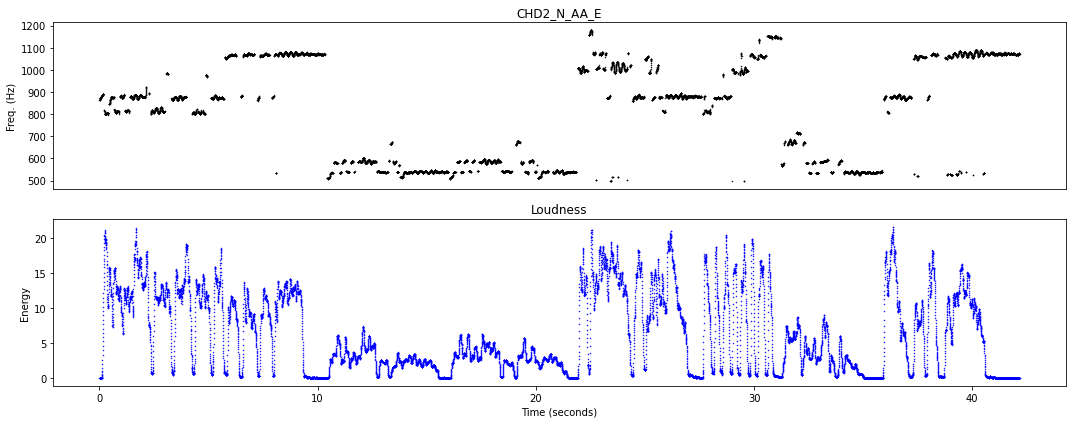

	Done!

Processing KDC-CR/CHD2_T_MH_E.flac (row #21)
	Annotated Minf0: 120.0	Maxf0: 340.0	f0_cf: 0.7	Duration: 41
	Computed  Minf0: 124.0	Maxf0: 335.0
	Loudness computed!


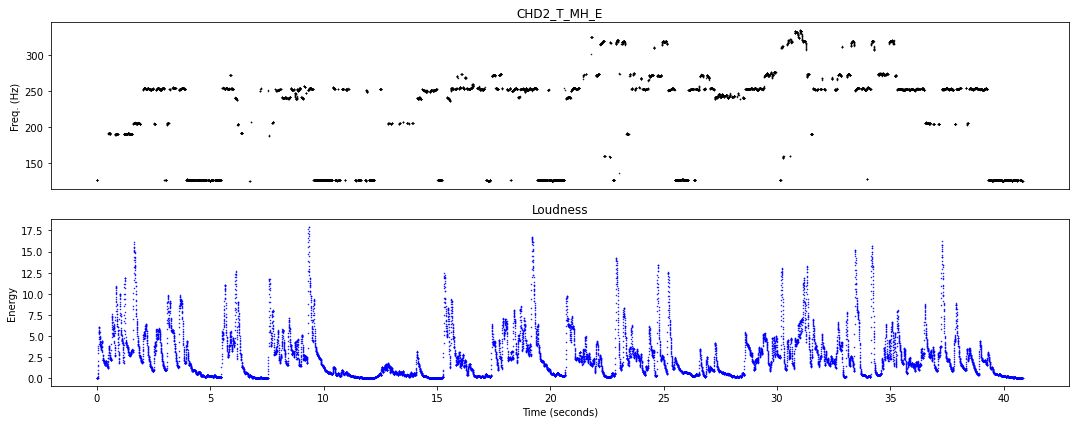

	Done!

Processing KDC-CR/CHD3_T_MH_E.flac (row #22)
	Annotated Minf0: 120.0	Maxf0: 340.0	f0_cf: 0.7	Duration: 37
	Computed  Minf0: 123.0	Maxf0: 333.0
	Loudness computed!


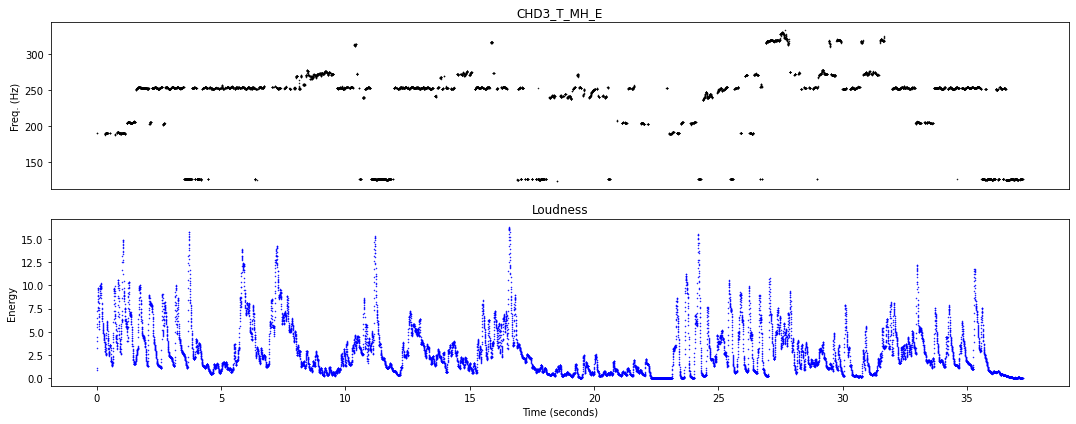

	Done!

Processing KDC-OR/DAD_N_MKH_B.flac (row #23)
	Annotated Minf0: 510.0	Maxf0: 1100.0	f0_cf: 0.9	Duration: 53
	Computed  Minf0: 507.0	Maxf0: 1087.0
	Loudness computed!


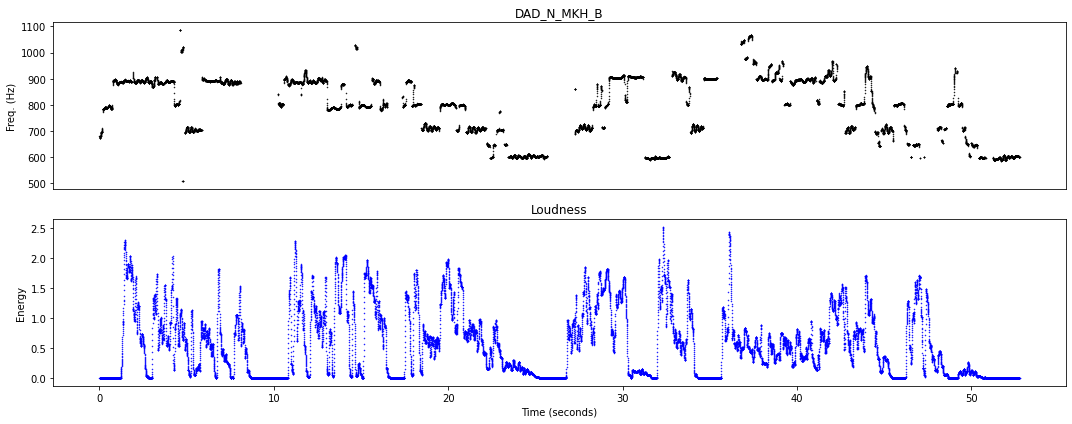

	Done!

Processing KDC-OR/DAD_N_MKH_E.flac (row #24)
	Annotated Minf0: 510.0	Maxf0: 1230.0	f0_cf: 0.9	Duration: 99
	Computed  Minf0: 511.0	Maxf0: 1260.0
	Loudness computed!


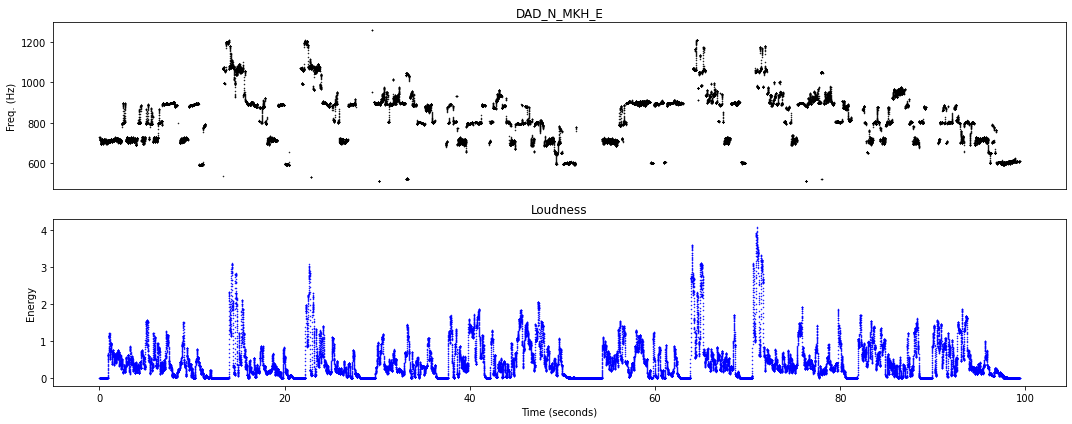

	Done!

Processing KDC-CR/DAD1_T_MH_E.flac (row #25)
	Annotated Minf0: 120.0	Maxf0: 350.0	f0_cf: 0.6	Duration: 36
	Computed  Minf0: 123.0	Maxf0: 345.0
	Loudness computed!


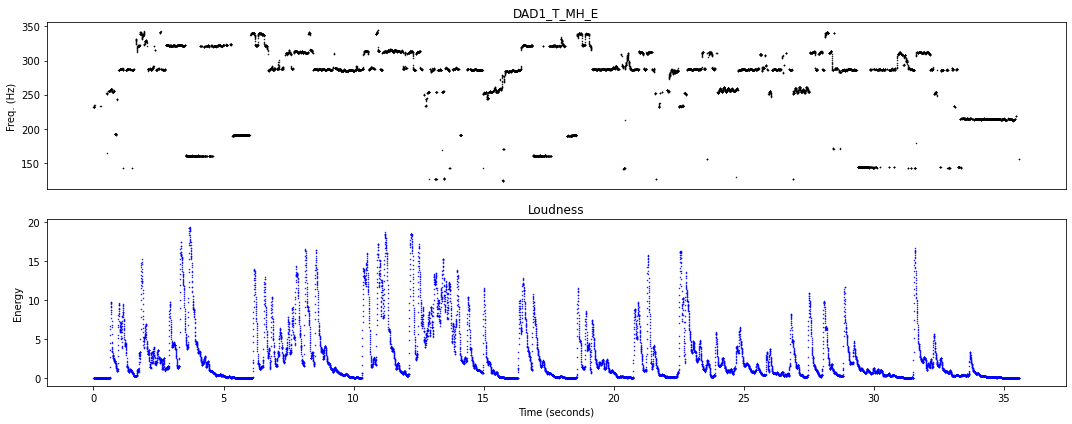

	Done!

Processing KDC-CR/DAD2_T_MH_E.flac (row #26)
	Annotated Minf0: 120.0	Maxf0: 400.0	f0_cf: 0.7	Duration: 54
	Computed  Minf0: 126.0	Maxf0: 394.0
	Loudness computed!


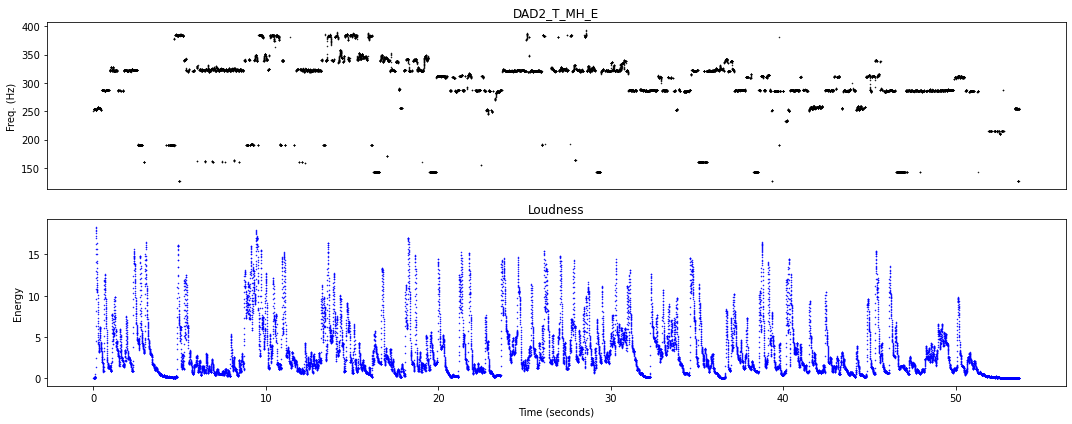

	Done!

Processing KDC-CR/DAD3_T_MH_E.flac (row #27)
	Annotated Minf0: 120.0	Maxf0: 400.0	f0_cf: 0.6	Duration: 69
	Computed  Minf0: 119.0	Maxf0: 401.0
	Loudness computed!


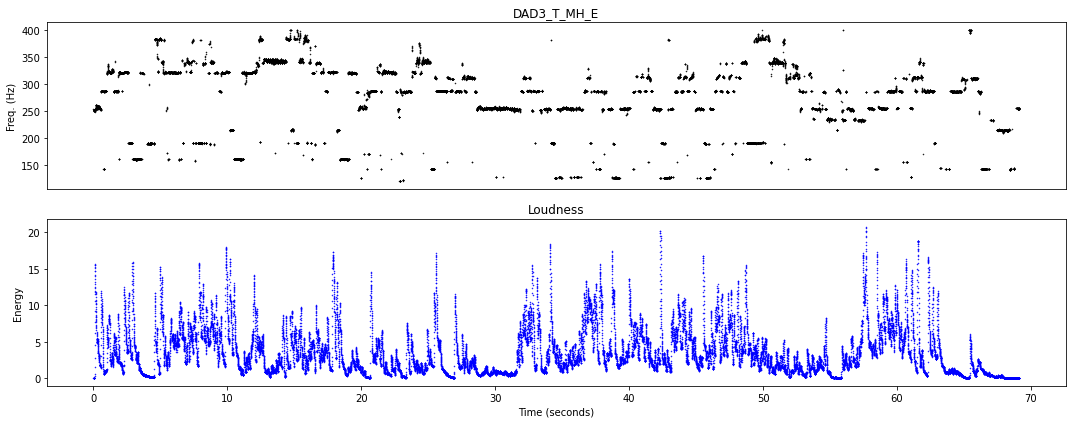

	Done!

Processing KDC-OR/ESD_N_MKH_B.flac (row #28)
	Annotated Minf0: 280.0	Maxf0: 480.0	f0_cf: 0.55	Duration: 31
	Computed  Minf0: 281.0	Maxf0: 474.0
	Loudness computed!


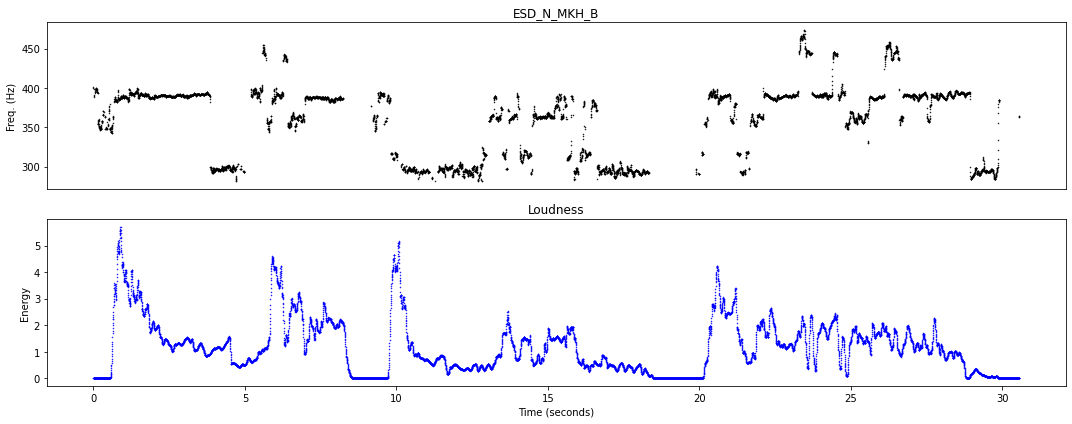

	Done!

Processing KDC-OR/ESD_N_MKH_E.flac (row #29)
	Annotated Minf0: 280.0	Maxf0: 480.0	f0_cf: 0.55	Duration: 104
	Computed  Minf0: 279.0	Maxf0: 482.0
	Loudness computed!


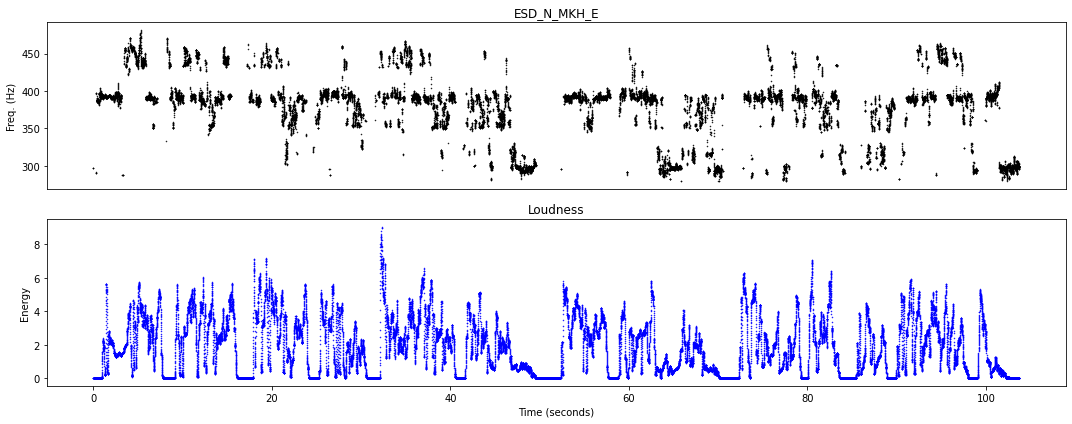

	Done!

Processing KDC-OR/HOD_N_MKH_B.flac (row #30)
	Annotated Minf0: 240.0	Maxf0: 440.0	f0_cf: 0.45	Duration: 29
	Computed  Minf0: 243.0	Maxf0: 433.0
	Loudness computed!


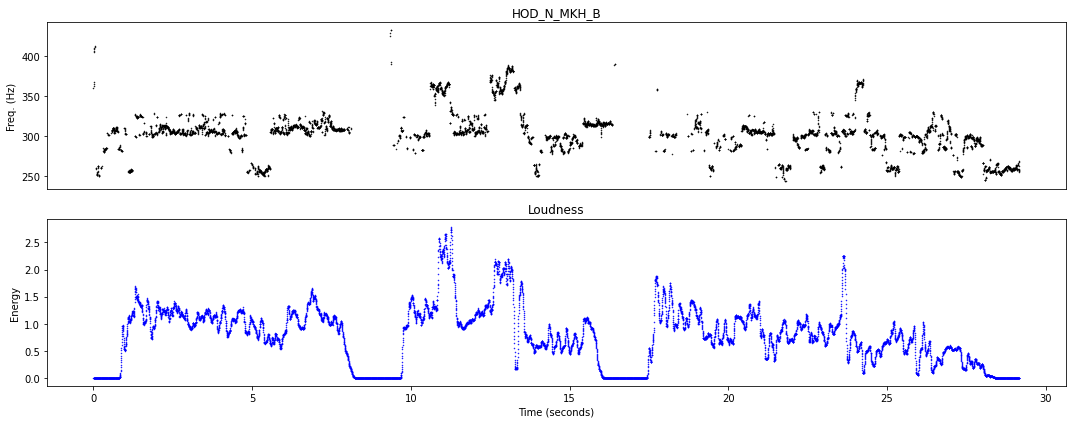

	Done!

Processing KDC-OR/HOD_N_MKH_E.flac (row #31)
	Annotated Minf0: 240.0	Maxf0: 1340.0	f0_cf: 0.5	Duration: 63
	Computed  Minf0: 242.0	Maxf0: 1378.0
	Loudness computed!


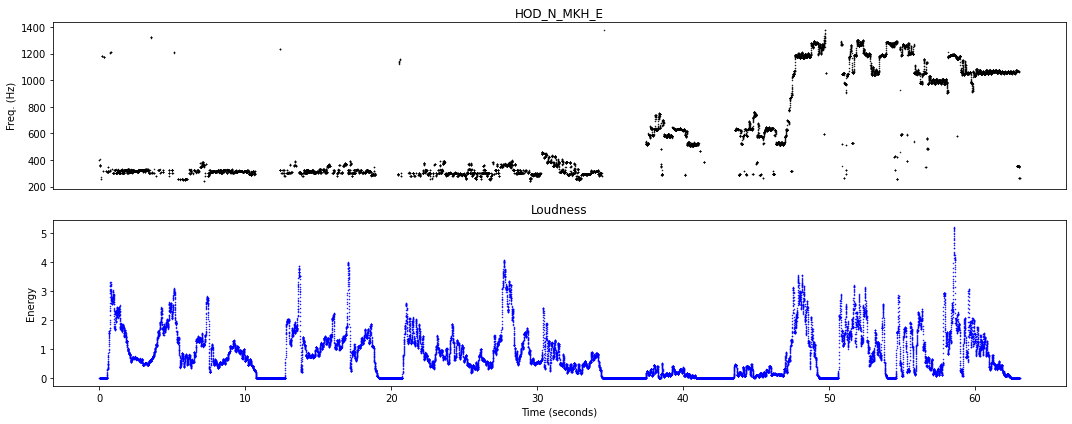

	Done!

Processing KDC-CR/MAD_A_MK_E.flac (row #32)
	Annotated Minf0: 100.0	Maxf0: 280.0	f0_cf: 0.65	Duration: 732
	Computed  Minf0: 100.0	Maxf0: 281.0
	Loudness computed!


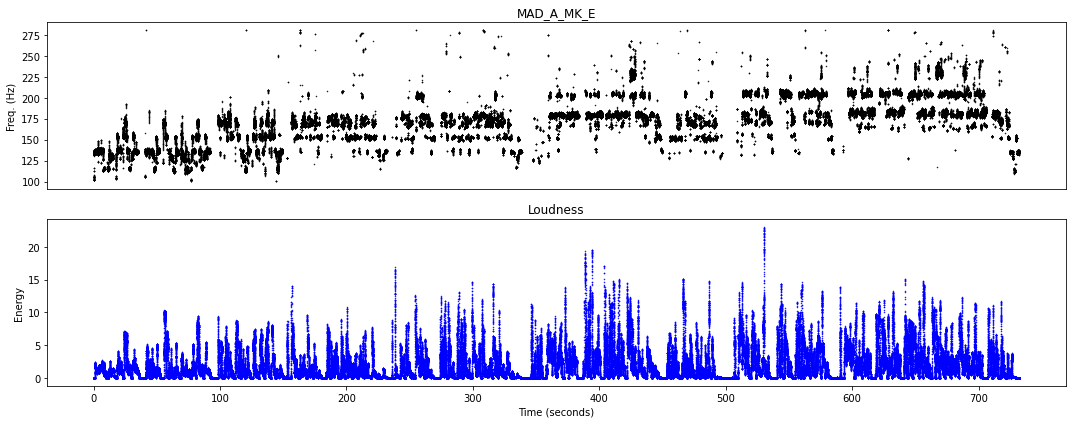

	Done!

Processing KDC-CR/MAD_A&T_MSH&DT_E.flac (row #33)
	Annotated Minf0: 150.0	Maxf0: 500.0	f0_cf: 0.8	Duration: 649
	Computed  Minf0: 151.0	Maxf0: 501.0
	Loudness computed!


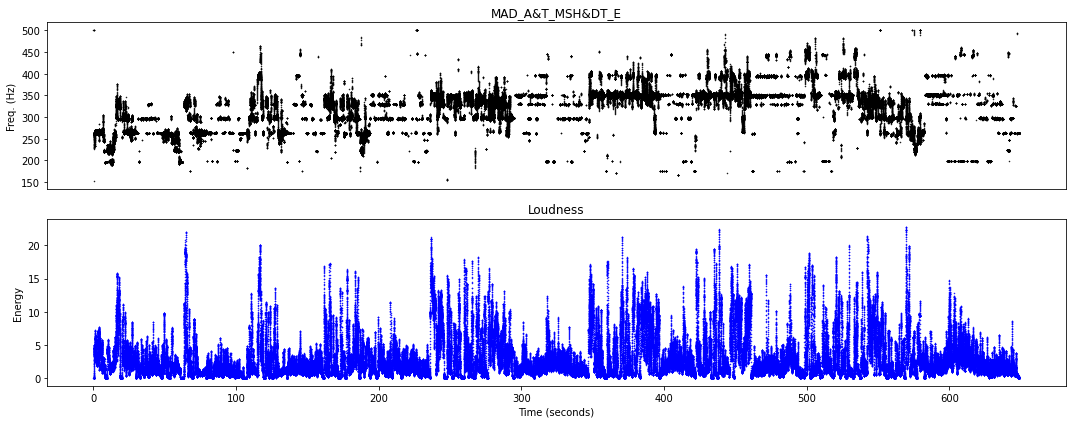

	Done!

Processing KDC-CR/MAD_K_NKH_E.flac (row #34)
	Annotated Minf0: 122.0	Maxf0: 765.0	f0_cf: 0.8	Duration: 299
	Computed  Minf0: 123.0	Maxf0: 765.0
	Loudness computed!


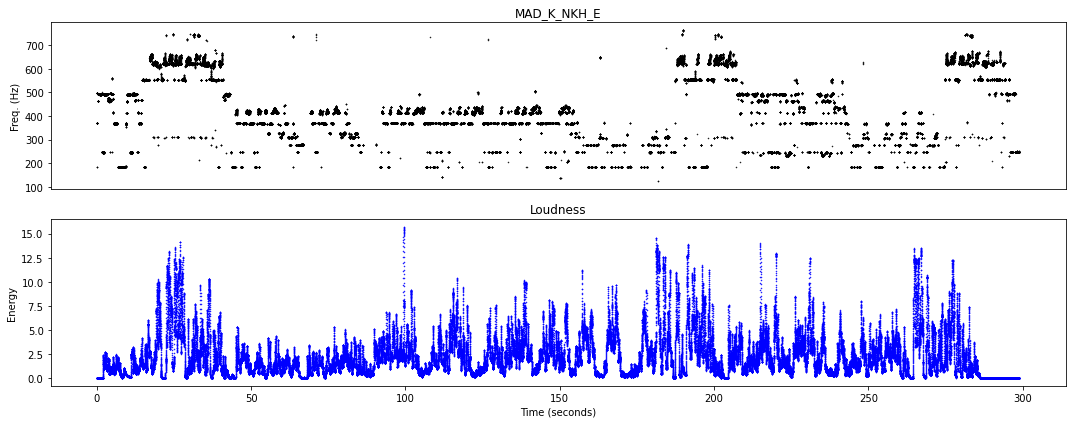

	Done!

Processing KDC-CR/MAD_N_HK_E.flac (row #35)
	Annotated Minf0: 167.0	Maxf0: 1384.0	f0_cf: 0.85	Duration: 859
	Computed  Minf0: 167.0	Maxf0: 1384.0
	Loudness computed!


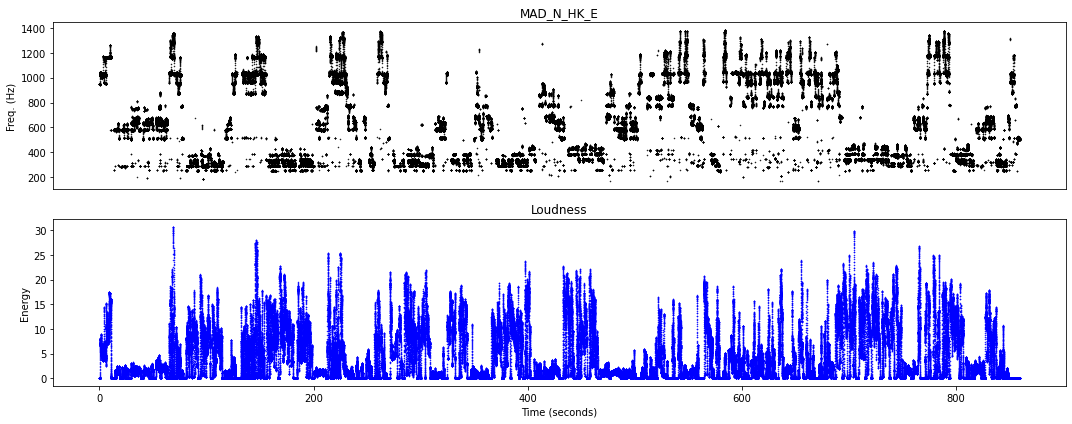

	Done!

Processing KDC-OR/MAD_N_MKH_B.flac (row #36)
	Annotated Minf0: 755.0	Maxf0: 1299.0	f0_cf: 0.85	Duration: 30
	Computed  Minf0: 755.0	Maxf0: 1299.0
	Loudness computed!


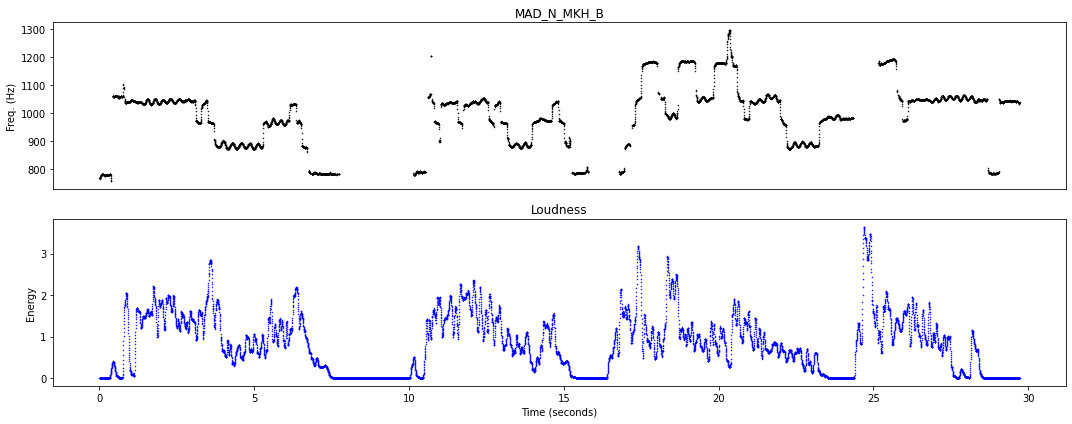

	Done!

Processing KDC-OR/MAD_N_MKH_E.flac (row #37)
	Annotated Minf0: 769.0	Maxf0: 1436.0	f0_cf: 0.9	Duration: 71
	Computed  Minf0: 769.0	Maxf0: 1436.0
	Loudness computed!


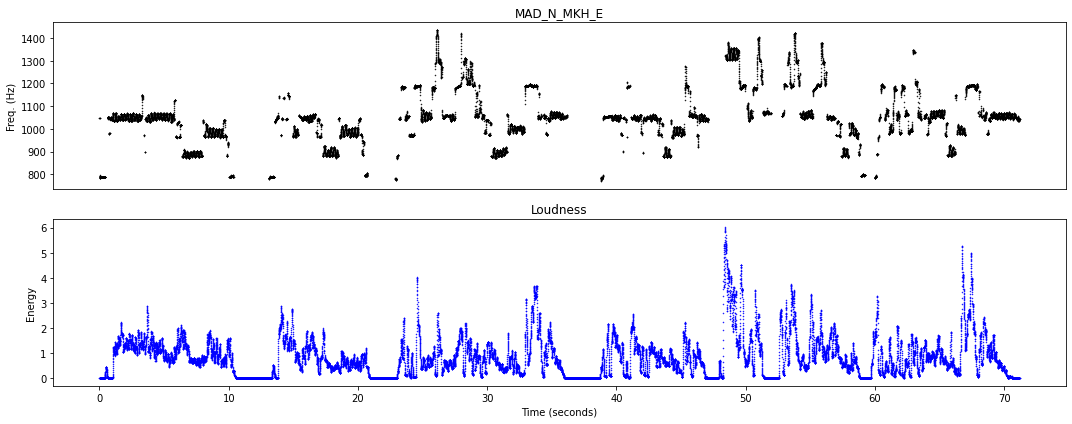

	Done!

Processing KDC-CR/NAD_A&N_MSH&HN_E.flac (row #38)
	Annotated Minf0: 120.0	Maxf0: 1110.0	f0_cf: 0.7	Duration: 364
	Computed  Minf0: 122.0	Maxf0: 1106.0
	Loudness computed!


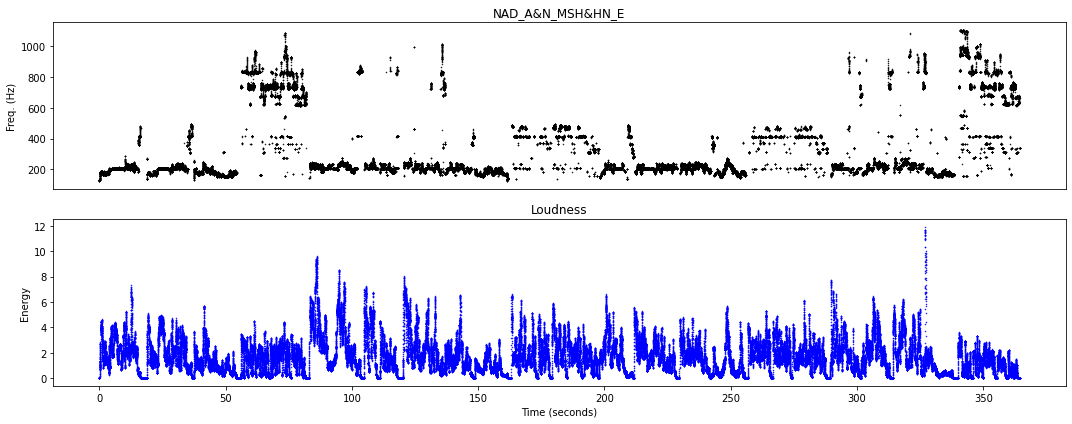

	Done!

Processing KDC-OR/NAD_N_MKH_B.flac (row #39)
	Annotated Minf0: 580.0	Maxf0: 950.0	f0_cf: 0.9	Duration: 37
	Computed  Minf0: 582.0	Maxf0: 948.0
	Loudness computed!


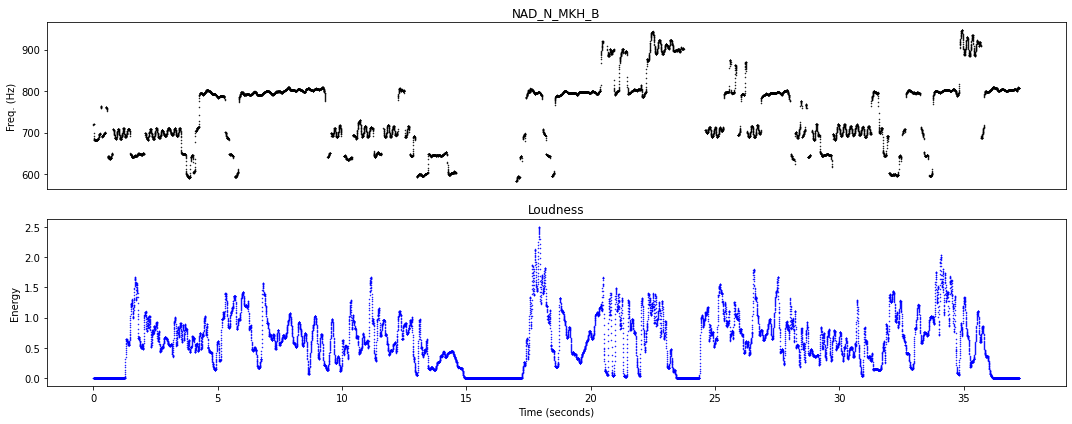

	Done!

Processing KDC-OR/NAD_N_MKH_E.flac (row #40)
	Annotated Minf0: 220.0	Maxf0: 1080.0	f0_cf: 0.7	Duration: 82
	Computed  Minf0: 219.0	Maxf0: 1102.0
	Loudness computed!


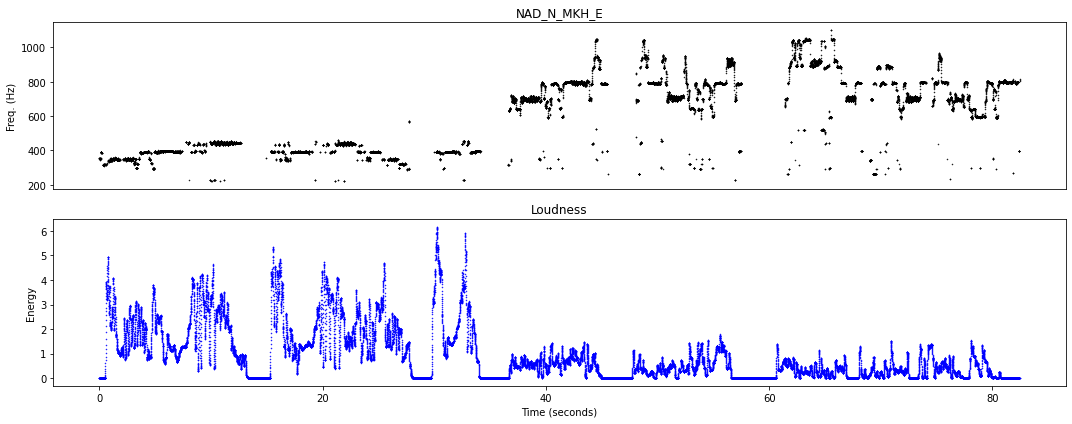

	Done!

Processing KDC-CR/NAD_T_HA_E.flac (row #41)
	Annotated Minf0: 120.0	Maxf0: 440.0	f0_cf: 0.7	Duration: 230
	Computed  Minf0: 119.0	Maxf0: 441.0
	Loudness computed!


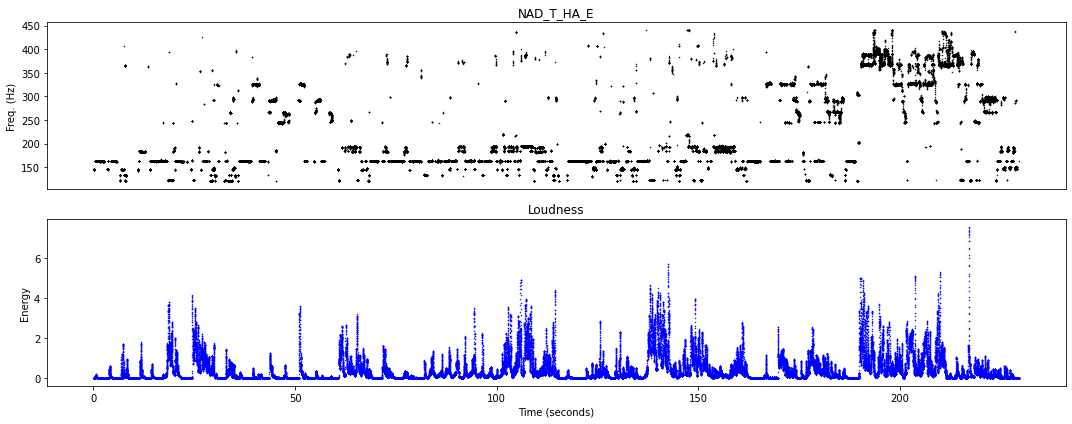

	Done!

Processing KDC-CR/NAD1_T_MH_E.flac (row #42)
	Annotated Minf0: 140.0	Maxf0: 260.0	f0_cf: 0.6	Duration: 34
	Computed  Minf0: 142.0	Maxf0: 258.0
	Loudness computed!


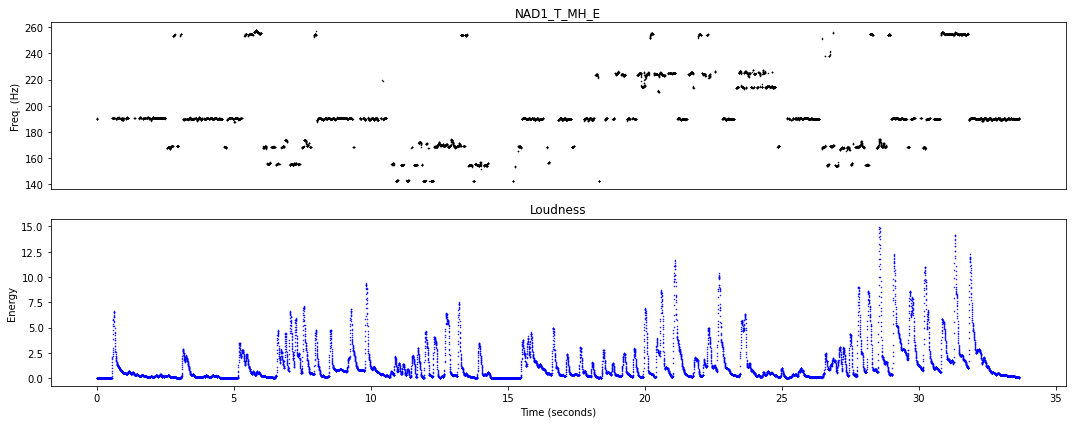

	Done!

Processing KDC-CR/NAD2_T_MH_E.flac (row #43)
	Annotated Minf0: 140.0	Maxf0: 260.0	f0_cf: 0.6	Duration: 59
	Computed  Minf0: 141.0	Maxf0: 261.0
	Loudness computed!


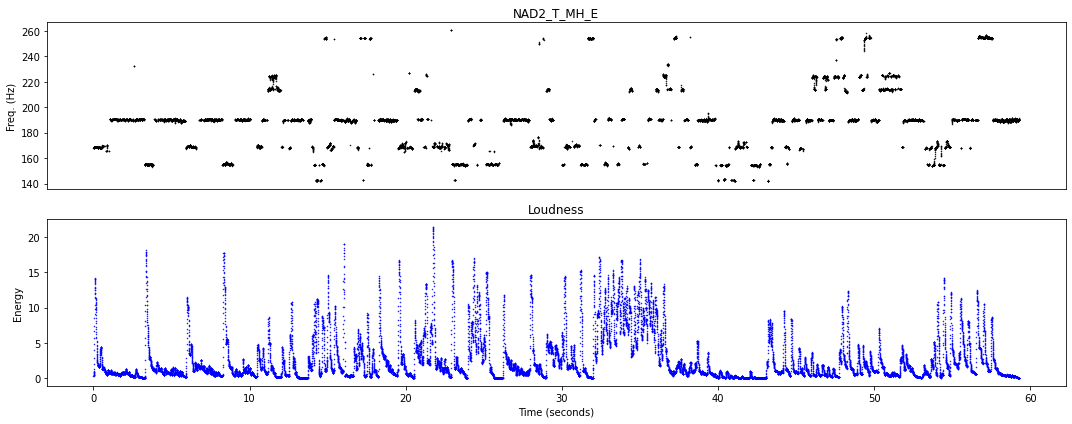

	Done!

Processing KDC-OR/RAD_N_MKH_B.flac (row #44)
	Annotated Minf0: 500.0	Maxf0: 1200.0	f0_cf: 0.9	Duration: 58
	Computed  Minf0: 506.0	Maxf0: 1196.0
	Loudness computed!


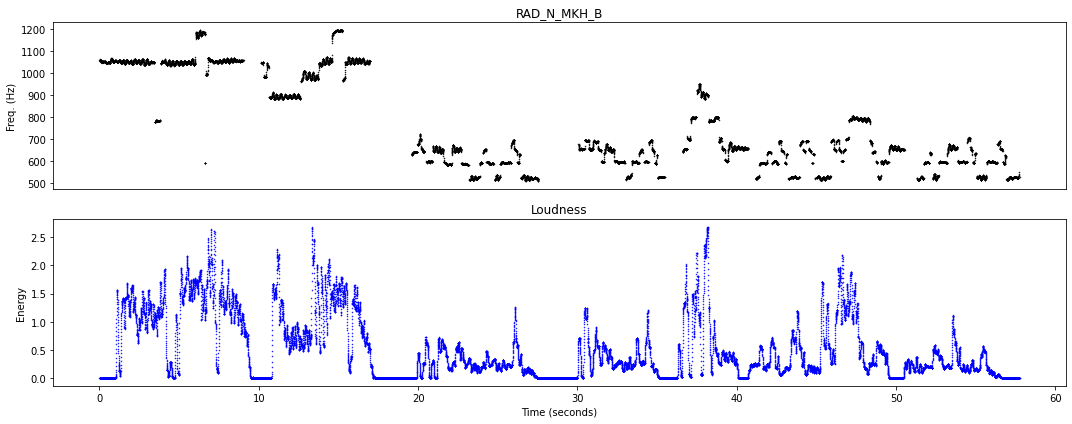

	Done!

Processing KDC-OR/RAD_N_MKH_E.flac (row #45)
	Annotated Minf0: 210.0	Maxf0: 1200.0	f0_cf: 0.6	Duration: 100
	Computed  Minf0: 214.0	Maxf0: 1225.0
	Loudness computed!


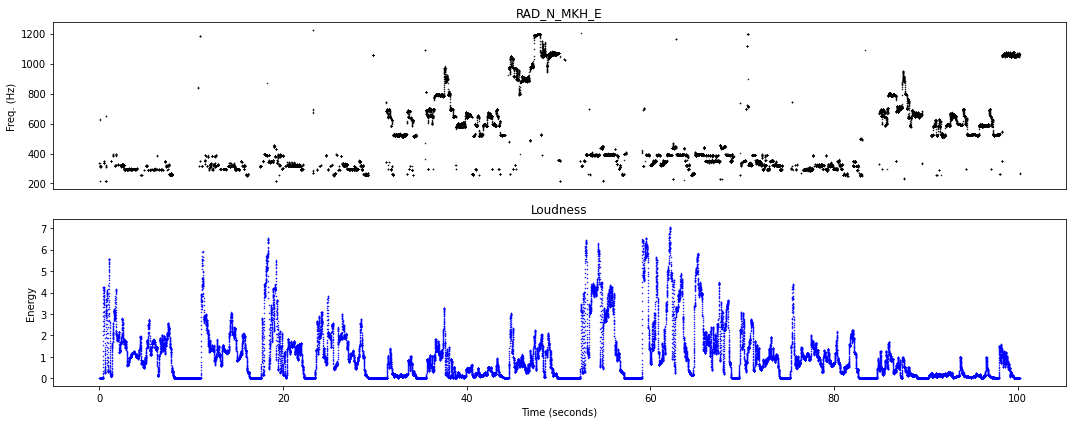

	Done!

Processing KDC-CR/RAD_T_MH_E.flac (row #46)
	Annotated Minf0: 100.0	Maxf0: 220.0	f0_cf: 0.5	Duration: 46
	Computed  Minf0: 106.0	Maxf0: 221.0
	Loudness computed!


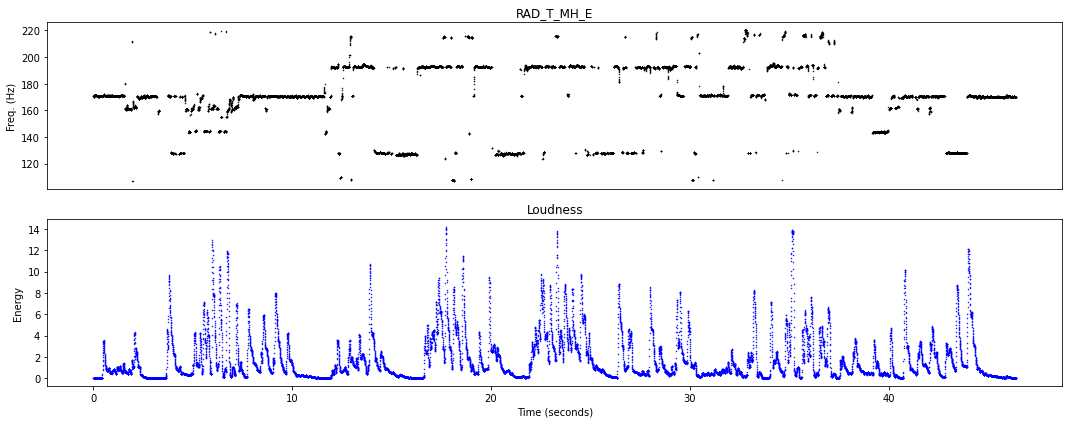

	Done!

Processing KDC-CR/SED_A&S_MSH&FP_E.flac (row #47)
	Annotated Minf0: 200.0	Maxf0: 360.0	f0_cf: 0.9	Duration: 555
	Computed  Minf0: 199.0	Maxf0: 356.0
	Loudness computed!


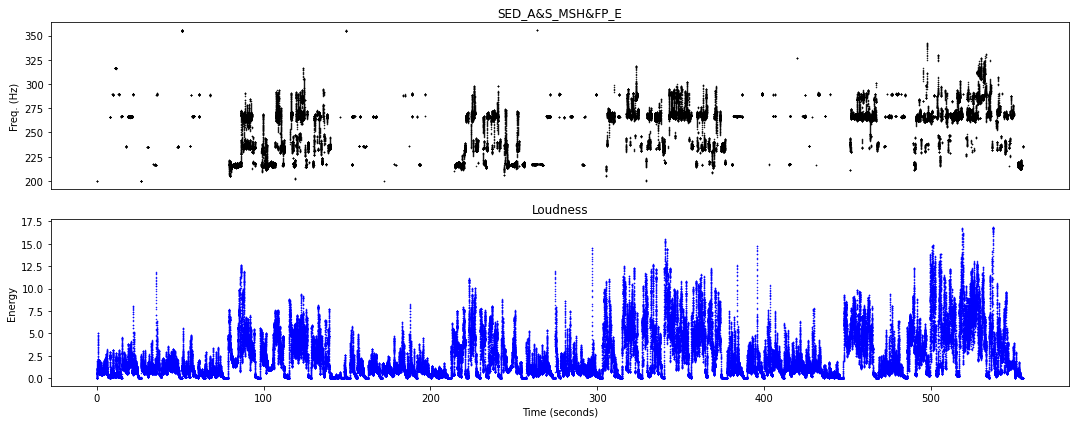

	Done!

Processing KDC-CR/SED_N_HK_E.flac (row #48)
	Annotated Minf0: 190.0	Maxf0: 650.0	f0_cf: 0.7	Duration: 180
	Computed  Minf0: 192.0	Maxf0: 643.0
	Loudness computed!


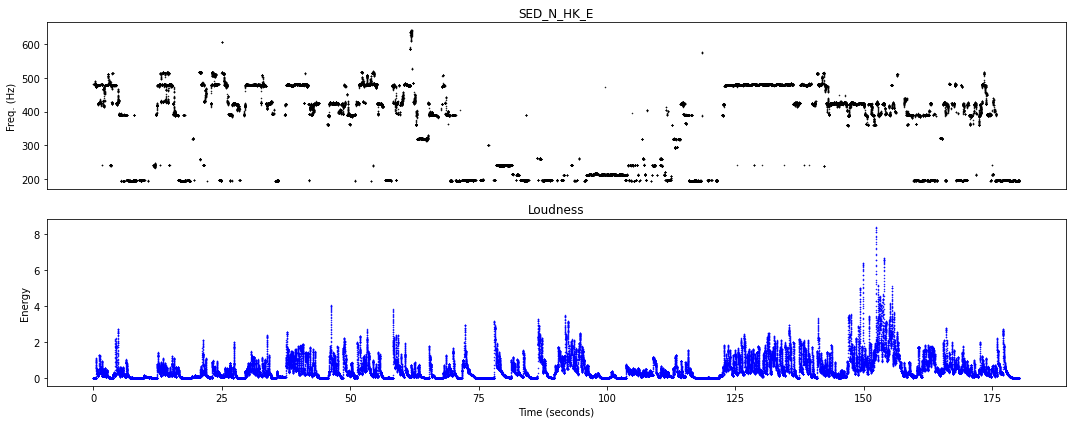

	Done!

Processing KDC-OR/SED_N_MKH_B.flac (row #49)
	Annotated Minf0: 240.0	Maxf0: 450.0	f0_cf: 0.5	Duration: 54
	Computed  Minf0: 247.0	Maxf0: 450.0
	Loudness computed!


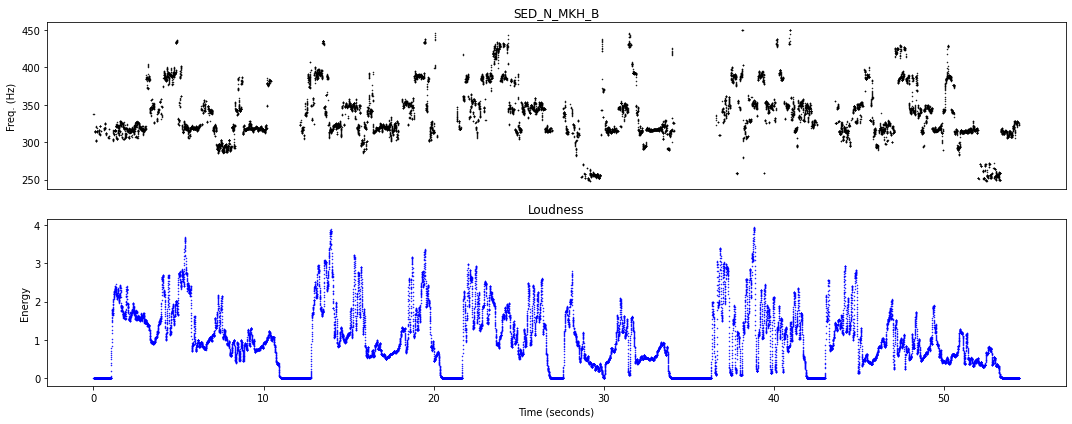

	Done!

Processing KDC-OR/SED_N_MKH_E.flac (row #50)
	Annotated Minf0: 240.0	Maxf0: 1320.0	f0_cf: 0.6	Duration: 120
	Computed  Minf0: 248.0	Maxf0: 1336.0
	Loudness computed!


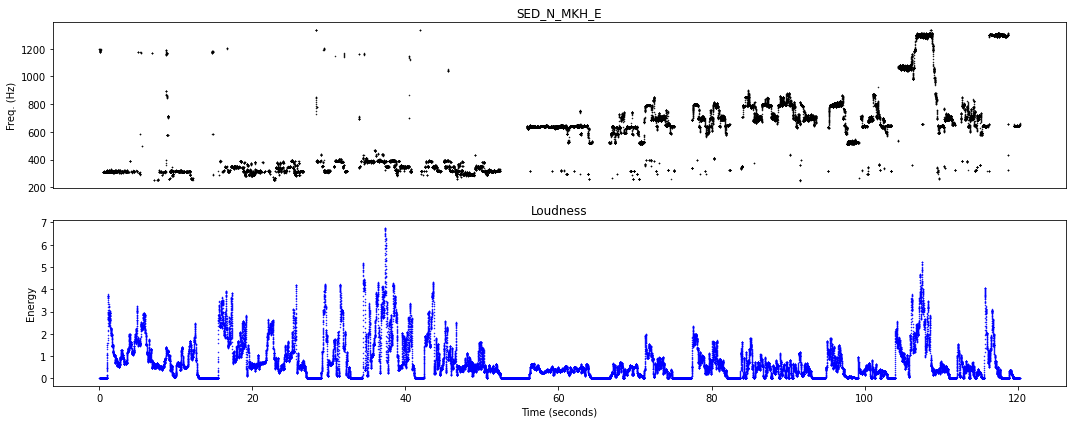

	Done!

Processing KDC-CR/SED_S_DT_E.flac (row #51)
	Annotated Minf0: 190.0	Maxf0: 650.0	f0_cf: 0.6	Duration: 180
	Computed  Minf0: 192.0	Maxf0: 643.0
	Loudness computed!


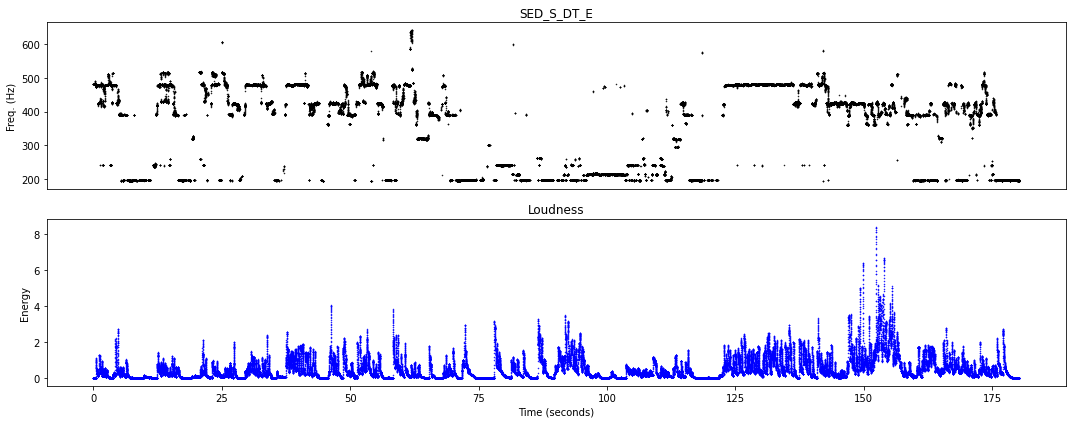

	Done!

Processing KDC-CR/SED_T_HA_E.flac (row #52)
	Annotated Minf0: 140.0	Maxf0: 610.0	f0_cf: 0.8	Duration: 133
	Computed  Minf0: 146.0	Maxf0: 607.0
	Loudness computed!


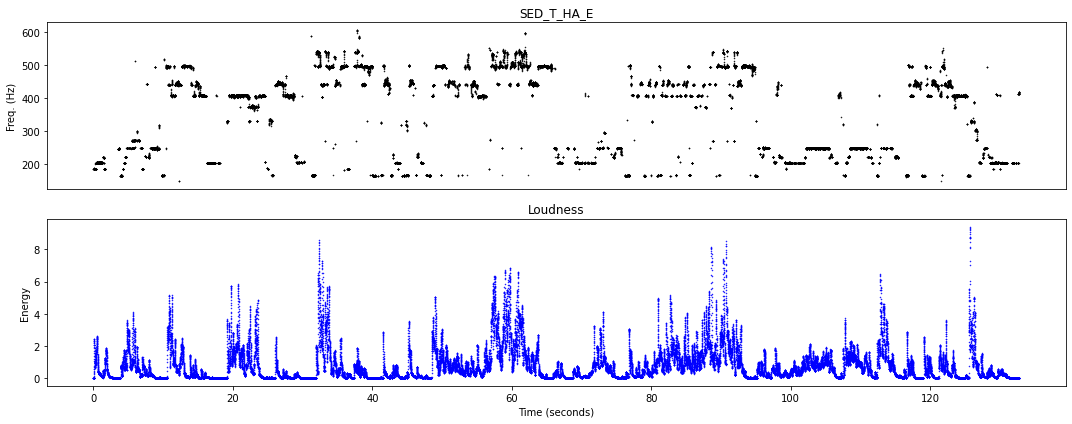

	Done!

Processing KDC-CR/SED1_T_MH_E.flac (row #53)
	Annotated Minf0: 150.0	Maxf0: 440.0	f0_cf: 0.6	Duration: 32
	Computed  Minf0: 150.0	Maxf0: 441.0
	Loudness computed!


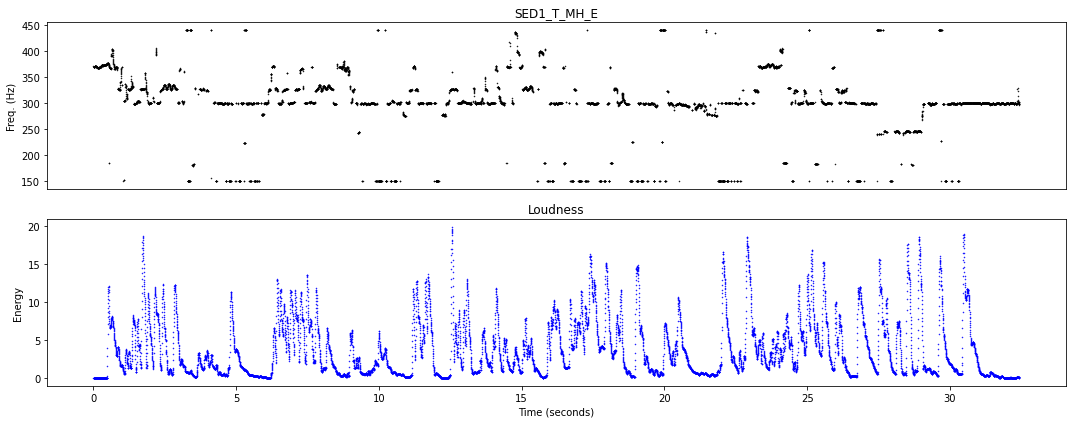

	Done!

Processing KDC-CR/SED2_T_MH_E.flac (row #54)
	Annotated Minf0: 150.0	Maxf0: 500.0	f0_cf: 0.6	Duration: 62
	Computed  Minf0: 150.0	Maxf0: 490.0
	Loudness computed!


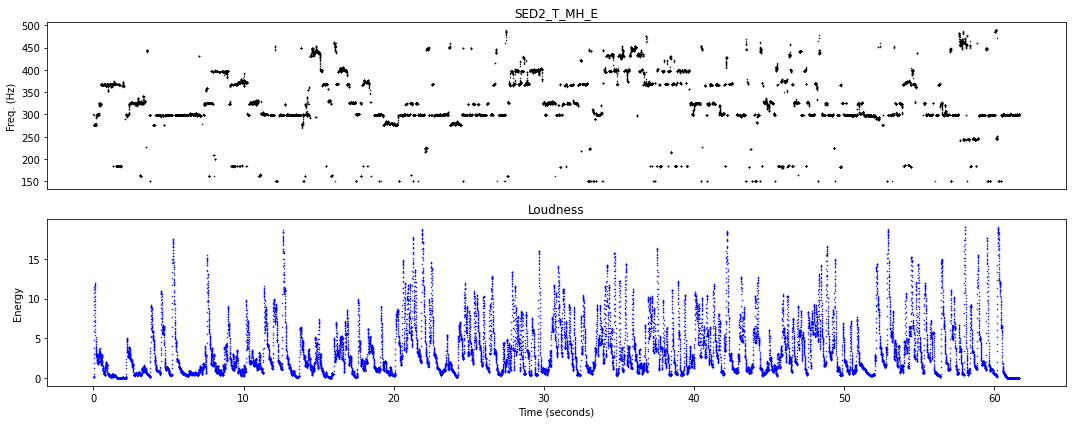

	Done!

Processing KDC-OR/SHD_N_MKH_B.flac (row #55)
	Annotated Minf0: 240.0	Maxf0: 470.0	f0_cf: 0.5	Duration: 37
	Computed  Minf0: 248.0	Maxf0: 462.0
	Loudness computed!


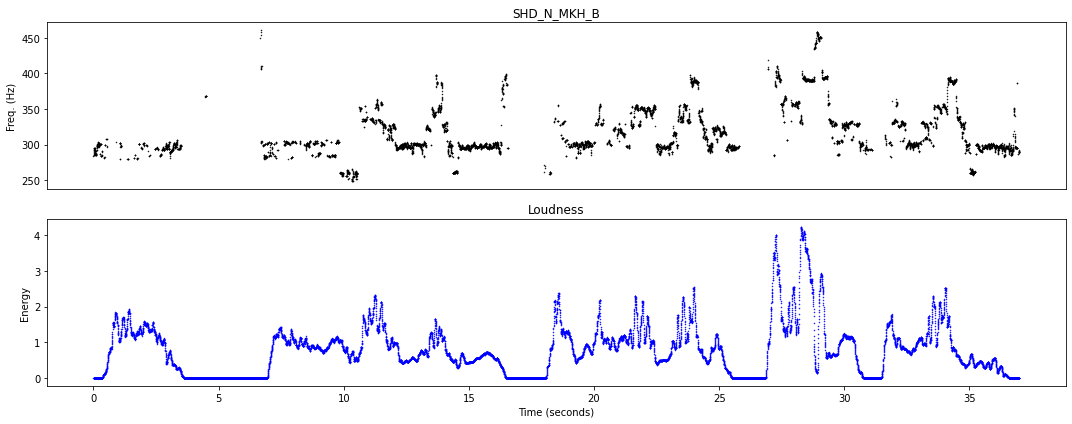

	Done!

Processing KDC-OR/SHD_N_MKH_E.flac (row #56)
	Annotated Minf0: 240.0	Maxf0: 1330.0	f0_cf: 0.5	Duration: 53
	Computed  Minf0: 249.0	Maxf0: 1336.0
	Loudness computed!


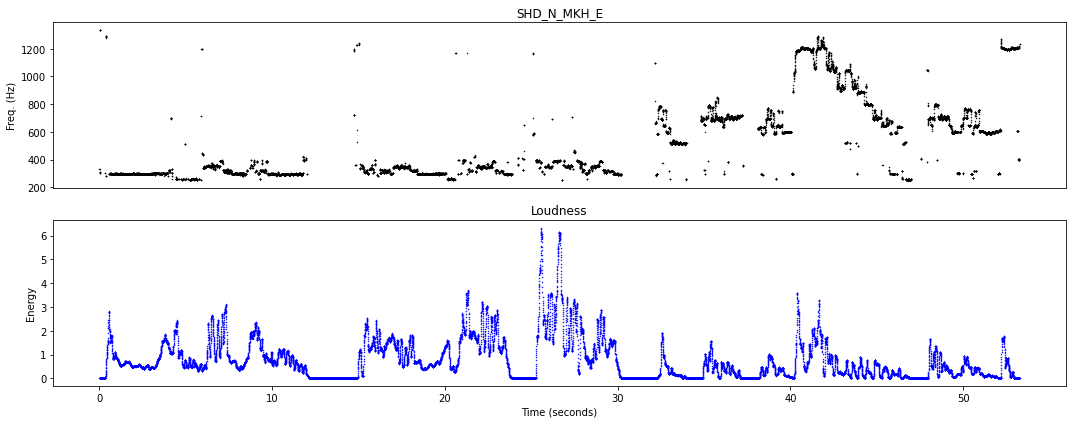

	Done!

Processing KDC-CR/SHD1_T_MH_E.flac (row #57)
	Annotated Minf0: 130.0	Maxf0: 300.0	f0_cf: 0.5	Duration: 31
	Computed  Minf0: 134.0	Maxf0: 300.0
	Loudness computed!


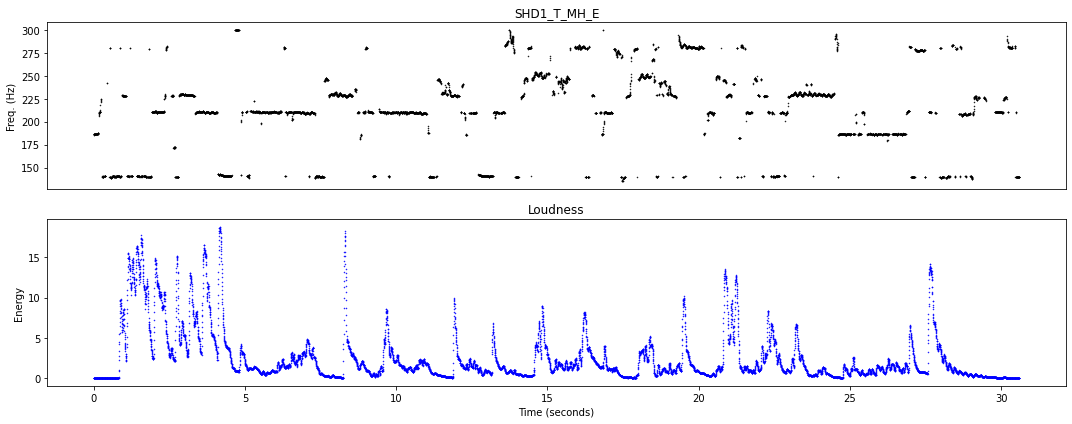

	Done!

Processing KDC-CR/SHD2_T_MH_E.flac (row #58)
	Annotated Minf0: 130.0	Maxf0: 300.0	f0_cf: 0.5	Duration: 42
	Computed  Minf0: 138.0	Maxf0: 300.0
	Loudness computed!


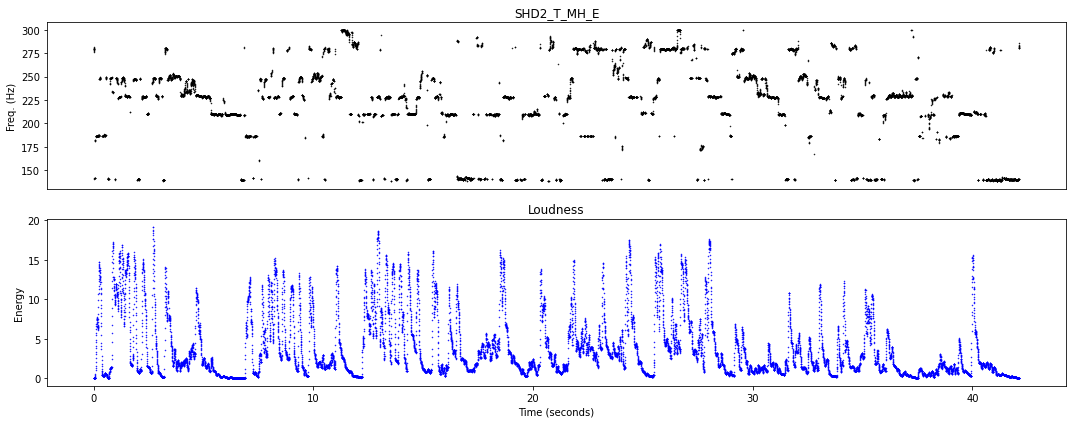

	Done!


All files computed!


In [5]:
loud = es.Loudness()

pt_folder = os.path.join(kdc_folder, 'loudness')
try:
    os.mkdir(pt_folder)
    os.mkdir(os.path.join(pt_folder, 'KDC-CR'))
    os.mkdir(os.path.join(pt_folder, 'KDC-OR'))
except:
    print('(The loudness folder already exists)\n')

plt.rcParams['figure.figsize'] = (15, 6)

for i in range(20, len(kdc_data)):
    # Process data
    row = kdc_data[i]
    row_data = row.rstrip().split(';')
    col_folder = 'KDC-'+row_data[1]
    filename = row_data[0]
    print('Processing {}/{} (row #{})'.format(col_folder, filename, i))
    recording_path = os.path.join(kdc_folder, col_folder, filename)
    loader = es.MonoLoader(filename=recording_path)
    audio = eqLoud(loader())
    shahed = float(row_data[7])
    minf0 = float(row_data[8])
    maxf0 = float(row_data[9])
    f0_cf = float(row_data[10])
    duration = row_data[11]
    print('\tAnnotated Minf0: {}\tMaxf0: {}\tf0_cf: {}\tDuration: {}'.format(minf0, maxf0, f0_cf, duration))
    # Compute pitchtrack
    f0 = eu.get_f0(audio, minf0=minf0, maxf0=maxf0, cf=f0_cf, ws=windowSize, hs=hopSize)
    print('\tComputed  Minf0: {}\tMaxf0: {}'.format(np.floor(min(f0[f0>0])), np.ceil(max(f0))))
    # Compute loudness
    loudTrack = []
    for frame in es.FrameGenerator(audio, frameSize=2048, hopSize=hopSize):
        frameLoud = loud(frame)
        loudTrack.append(frameLoud)
    print('\tLoudness computed!')
    # Plotting
    fileGenName = os.path.join(pt_folder, col_folder, filename[:-5])
    timeStamps = np.arange(f0.size)*hopSize/44100
    plt.figure()
    plt.subplot(211)
    plt.plot(timeStamps[f0>0], f0[f0>0], '.k', markersize=1)
    plt.title(filename.split('.')[0])
    plt.ylabel('Freq. (Hz)')
    plt.xticks([])
    plt.subplot(212)
    plt.plot(timeStamps, loudTrack, '.b', markersize=1)
    plt.title('Loudness')
    plt.ylabel('Energy')
    plt.xlabel('Time (seconds)')
    plt.tight_layout()
    plt.savefig(fileGenName + '-loudness.png')
    plt.show()
    print('\tDone!\n')
    
print('\nAll files computed!')    

### First and last note

In [ ]:
def midi2Hz(midi):
    '''
    Converts a given midi value to its equivalent in hertz
    
    Args:
        midi (str): midi value as string
        
    Returns:
        frequency (str): equivalent frequency in Hertz as string
        
    >>> midi2Hz('60')
    '261.6255653005986'
    '''
    f = 2 ** ((float(midi) - 69) / 12.) * 440
    return str(f)

In [ ]:
pitchContourSegmentation = es.PitchContourSegmentation()

In [ ]:
pt_folder = os.path.join(kdc_folder, 'firstAndLast')
try:
    os.mkdir(pt_folder)
    os.mkdir(os.path.join(pt_folder, 'KDC-CR'))
    os.mkdir(os.path.join(pt_folder, 'KDC-OR'))
except:
    print('(The firstAndLast folder already exists)\n')

for i in range(5, 19):
    # Process data
    row = kdc_data[i]
    row_data = row.rstrip().split(';')
    col_folder = 'KDC-'+row_data[1]
    filename = row_data[0]
    print('Processing {}/{} (row #{})'.format(col_folder, filename, i))
    recording_path = os.path.join(kdc_folder, col_folder, filename)
    loader = es.MonoLoader(filename=recording_path)
    audio = eqLoud(loader())
    shahed = row_data[7]
    minf0 = float(row_data[8])
    maxf0 = float(row_data[9])
    f0_cf = float(row_data[10])
    duration = row_data[11]
    print('\tAnnotated Minf0: {}\tMaxf0: {}\tf0_cf: {}\tDuration: {}'.format(minf0, maxf0, f0_cf, duration))
    # Compute pitchtrack
    f0 = eu.get_f0(audio, minf0=minf0, maxf0=maxf0, cf=f0_cf, ws=windowSize, hs=hopSize)
    print('\tComputed  Minf0: {}\tMaxf0: {}'.format(np.floor(min(f0[f0>0])), np.ceil(max(f0))))
    # Compute notes
    midiNotes = pitchContourSegmentation(essentia.array(f0), audio)
    txt2write = ''
    for i in range(len(midiNotes[0])):
        txt2write += str(midiNotes[0][i]) + '\t' + str(midiNotes[1][i]) + '\t' + midi2Hz(midiNotes[2][i]) + '\n'
    fileGenName = os.path.join(pt_folder, col_folder, filename[:-5])
    with open(fileGenName + '-notes.txt', 'w') as f:
        f.write(txt2write.rstrip())
    print('\tNotes computed')
    
    # Search first and last notes
    first_start = midiNotes[0][0]
    first_end = first_start + midiNotes[1][0]
    i = 0
    j = 0
    dur = midiNotes[1][0]
    longNoteFound = False
    longNoteDuration = 1
    while longNoteFound == False:
        try:
            while dur < longNoteDuration:
                i += 1
                j = 0
                dur = midiNotes[1][i]
                print(dur, longNoteDuration)
                midi = midiNotes[2][i]
                while midiNotes[2][i+j+1] == midi:
                    dur += midiNotes[1][i+j+1]
                    j += 1
            longNoteFound = True
        except IndexError:
            longNoteDuration += -0.05
    first_long_start = midiNotes[0][i]
    first_long_end = first_long_start + dur
    print('\tFound first long note with a duration of {:.1f} seconds'.format(first_long_end - first_long_start))

    last_start = midiNotes[0][-1]
    last_end = last_start + midiNotes[1][-1]

    first_start_i = np.abs(timeStamps - first_start).argmin()
    first_end_i = np.abs(timeStamps - first_end).argmin()

    first_long_start_i = np.abs(timeStamps - first_long_start).argmin()
    first_long_end_i = np.abs(timeStamps - first_long_end).argmin()

    last_start_i = np.abs(timeStamps - last_start).argmin()
    last_end_i = np.abs(timeStamps - last_end).argmin()

    first = f0[first_start_i:first_end_i+1]
    first_long = f0[first_long_start_i:first_long_end_i+1]
    last = f0[last_start_i:last_end_i+1]
    
    # Create text file
    print('\t    Shahed:\t\t{}'.format(shahed))
    print('\t    1st note:\t{}'.format(round(np.mean(first))))
    print('\t    1st long note:\t{}'.format(round(np.mean(first_long))))
    print('\t    Last note:\t{}'.format(round(np.mean(last))))
    txt2write = 'Shahed:\t\t{}\n1st note:\t{}\n1st long note:\t{}\nLast note:\t{}'.format(shahed, round(np.mean(first)), round(np.mean(first_long)), round(np.mean(last)))
    with open(fileGenName + '-firstAndLast.txt', 'w') as f:
                f.write(txt2write.rstrip())
    print('\tDone!\n')
    
print('\nAll files computed!')

In [ ]:
min(loudTrack)